In [1]:
#This notebook builds similarity merger from baseline randomforest on pubchem_assays using 
#Morgan fingerprint 
#and cell painting

In [2]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from scipy import stats
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem.Scaffolds import MurckoScaffold
import pandas as pd
from tqdm import tqdm
import time
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef,confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

In [3]:
list_of_lists_df = pd.read_csv("Predictions_train_heldout_scaled_prob_all_assays_ensemble.csv")
list_of_lists_df

,assay,StdInChI,fp_proba,fp_pred,fp_threshold,CP_proba,CP_pred,CP_threshold,true,ts,pc,Data,MFP_Correct,CP_Correct,fp_proba_scaled,CP_proba_scaled,simple_pred,Ensemble_Correct
0,588458,"InChI=1S/C19H19N3O5S3/c23-16-6-5-13(30(25,26)2...",0.215985,0,0.278423,0.291141,0,0.306456,0.0,0.418605,0.430046,Training,True,True,0.387873,0.475014,0.0,True
1,588458,InChI=1S/C9H8ClN3S/c1-6-11-12-9(14)13(6)8-4-2-...,0.240910,0,0.278423,0.253367,0,0.306456,0.0,0.409091,0.680534,Training,True,True,0.432633,0.413382,0.0,True
2,588458,InChI=1S/C20H20N2O4/c1-2-25-20(24)17-12-18-16(...,0.232871,0,0.278423,0.154150,0,0.306456,0.0,0.447368,0.701574,Training,True,True,0.418196,0.251504,0.0,True
3,588458,InChI=1S/C26H24N2O5S/c1-33-19-11-9-18(10-12-19...,0.142133,0,0.278423,0.359792,1,0.306456,1.0,0.341463,0.453313,Training,False,True,0.255247,0.538452,0.0,False
4,588458,InChI=1S/C19H21N3O3S/c1-13-10-16-11-15(4-9-19(...,0.253998,0,0.278423,0.202499,0,0.306456,0.0,0.388889,0.646760,Training,True,True,0.456137,0.330388,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50467,1117305,InChI=1S/C12H9F3N2O2/c1-7-10(6-16-19-7)11(18)1...,0.340631,0,0.357222,0.357490,1,0.330242,0.0,0.296296,0.479437,HeldOut,True,False,0.476778,0.520342,0.0,True
50468,1117305,InChI=1S/C12H10N2/c1-8-12-10(6-7-13-8)9-4-2-3-...,0.242578,0,0.357222,0.244216,0,0.330242,0.0,0.363636,0.619949,HeldOut,True,True,0.339534,0.369752,0.0,True
50469,1117305,InChI=1S/C8H4Cl2N2O2/c9-3-1-5-6(2-4(3)10)12-8(...,0.403774,1,0.357222,0.352388,1,0.330242,1.0,0.333333,0.541732,HeldOut,True,True,0.536212,0.516533,1.0,True
50470,1117305,InChI=1S/C15H12O5/c16-9-3-1-8(2-4-9)13-7-12(19...,0.478660,1,0.357222,0.243638,0,0.330242,0.0,0.444444,0.506977,HeldOut,False,True,0.594464,0.368877,0.0,True


In [4]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    #print(nn)
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    #print ("def tree({}):" .format(", " .join(feature_names)))

    print("def treeee(X_train):")
    def recurse(node, depth):
       
        indent = "    " * depth

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            table = 'X_train'
            name = table+"['"+feature_name[node]+"']"
     
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            #print(nn)
            increment()
            print ("{}return 'Node_{}'".format(indent, nn))   
    recurse(0, 1)

In [5]:
def initialize(): 
    global nn 
    nn = 0
    
def increment():
    global nn 
    nn+=1

In [6]:
def initializek(): 
    global k 
    k = 1
    
def incrementk():
    global k 
    k+=1

In [7]:
from sklearn.linear_model import LogisticRegression
from io import StringIO
from itertools import product
import sys
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

In [93]:
def RF_Fn(assay):

    detail_list=pd.DataFrame()
    detail_list = list_of_lists_df[list_of_lists_df["assay"]==assay].reset_index(drop=True)
    
    
    proba_batch=[]
    pred_batch=[]
    true_batch=[]
    StdInChI_batch=[]
    
    train= detail_list[detail_list["Data"]=="Training"]
    
    #Sample Train data
    train_inactive = train[train["true"] == 0]
    inactives_n=len(train_inactive)
    print("Inactive Compounds ", inactives_n)

    train_active = train[train["true"] == 1]
    actives_n=len(train_active)
    print("Active Compounds ", actives_n)

    if(inactives_n > actives_n):
            train_inactive= train_inactive.sample(actives_n, random_state=1)
            print("Inactive Compounds (after Undersamplimg) ", len(train_inactive) )
            train= train_active.append(train_inactive) 
            print("Total Compounds (after Undersamplimg) ", len(train) )

    elif(actives_n > inactives_n):
            train_active= train_active.sample(inactives_n, random_state=1)
            print("Active Compounds (after Undersamplimg) ", len(train_active) )
            train= train_inactive.append(train_active) 
            print("Total Compounds (after Undersamplimg) ", len(train) )

    
    #test
    test= detail_list[detail_list["Data"]=="HeldOut"]
    
    train_x = train[["ts", "pc"]].to_numpy()
    train_y = train[["MFP_Correct","CP_Correct"]].to_numpy()
    #train_y = train[["true"]].to_numpy()
    
    test_x = test[["ts", "pc"]].to_numpy()
    #test_y = test[["MFP_Correct","CP_Correct"]].to_numpy()
    #test_y = test[["true"]].to_numpy()
    
        
    print(len(train_x))
    print(len(test_x))
    

    print("Herirachal model for training data")    

    classifier = DecisionTreeClassifier(random_state=42, max_depth=2)
    classifier.fit(train_x, train_y)
        
    fig = plt.figure(figsize=(5, 3))
    plot_tree(classifier, 
        feature_names = [ "td", "pc"],
        class_names = ["True", "False"],
        filled=True, impurity=True, 
        rounded=True)
    plt.show()
        
    # Plotting decision regions
    print(k)
    #plot_decision_regions_modified(test_x, test_y.astype(int), clf=classifier, legend=0) #, zoom_factor=1)
    plt.ylim(0, 1)
    plt.xlim(0, 1)

        
    #Tree to code
    columns = ["ts", "pc"]
        
    initialize() 
    #print(nn) # print the nn value 

    tag_list = ""
    for i in range(0,1):
        save_stdout = sys.stdout
        result = StringIO()
        sys.stdout = result
        tree_to_code(classifier, columns)
        sys.stdout = save_stdout
        tag_list+=(result.getvalue())
    script=str(tag_list)
    #print(script)
    exec(tag_list, globals())
        
    #Assign train and test data nodes from DT   
    test['node']=test.apply(treeee, axis=1)
    train['node']=train.apply(treeee, axis=1)
        
    for node in ["Node_1", "Node_2", "Node_3", "Node_4"]:
        #Run conditions/LR per node   
        
        train_node_set= train[train["node"]==node]
        #display(train_node_set.head(5))
        
        test_node_set= test[test["node"]==node]
        #display(test_node_set.head(5))    
        
        print(node)     
        print(train_node_set.shape)
        print(test_node_set.shape)

        if(len(train_node_set) == 0):
            if(len(test_node_set) != 0):   
                print("no train compounds but test compounds present, take average:")
                StdInChI = test_node_set["StdInChI"].to_numpy()
                proba = ((test_node_set["CP_proba_scaled"] +  test_node_set["fp_proba_scaled"])/2).to_numpy()
                pred =  [round(i) for i in proba]
                true = test_node_set["true"].to_numpy()

                StdInChI_batch = np.concatenate([StdInChI_batch, StdInChI])
                proba_batch = np.concatenate([proba_batch, proba])
                pred_batch = np.concatenate([pred_batch, pred])
                true_batch = np.concatenate([true_batch, true])
                    
                #print(len(pred_batch))
                #print(len(true_batch))
                continue
                
        elif(len(train_node_set["true"]) == sum(train_node_set["true"])):
            if(len(test_node_set) != 0):   
                print("only positive variables in train but test compounds present, take average:")
                    
                StdInChI = test_node_set["StdInChI"].to_numpy()
                proba = ((test_node_set["CP_proba_scaled"] +  test_node_set["fp_proba_scaled"])/2).to_numpy()
                pred =  [round(i) for i in proba]
                true = test_node_set["true"].to_numpy()
                    
                StdInChI_batch = np.concatenate([StdInChI_batch, StdInChI])
                proba_batch = np.concatenate([proba_batch, proba])
                pred_batch = np.concatenate([pred_batch, pred])
                true_batch = np.concatenate([true_batch, true])
                #print(len(pred_batch))
                #print(len(true_batch))
                continue
                    
        elif(sum(train_node_set["true"])==0):
            if(len(test_node_set) != 0):   
                print("only negative variables in train but test compounds present, take average:")
                    
                StdInChI = test_node_set["StdInChI"].to_numpy()
                proba = ((test_node_set["CP_proba_scaled"] +  test_node_set["fp_proba_scaled"])/2).to_numpy()
                pred =  [round(i) for i in proba]
                true = test_node_set["true"].to_numpy()
                    
                StdInChI_batch = np.concatenate([StdInChI_batch, StdInChI])
                proba_batch = np.concatenate([proba_batch, proba])
                pred_batch = np.concatenate([pred_batch, pred])
                true_batch = np.concatenate([true_batch, true])
                #print(len(pred_batch))
                #print(len(true_batch))
                continue
                
                        
        elif(len(test_node_set) == 0):   
            #print("no test compounds")
            #print(len(pred_batch))
            #print(len(true_batch))
            continue
            
                
        else:
            
            print("LR Model")
            
            X_train_node_set = train_node_set[["fp_proba_scaled", "CP_proba_scaled"]].to_numpy()
            y_train_node_set = train_node_set["true"].to_numpy()
            X_test_node_set = test_node_set[["fp_proba_scaled", "CP_proba_scaled"]].to_numpy()
            y_test_node_set = test_node_set["true"].to_numpy()


            classifier = LogisticRegression(C=5, random_state=42)            
            classifier.fit(X_train_node_set, y_train_node_set)

            #print(node)
            #print(classifier.coef_)

            StdInChI = test_node_set["StdInChI"].to_numpy()
            pred = classifier.predict(X_test_node_set) 
            proba = classifier.predict_proba(X_test_node_set)[:,1]
            true = test_node_set["true"].to_numpy()
            #break

            StdInChI_batch = np.concatenate([StdInChI_batch, StdInChI])
            proba_batch = np.concatenate([proba_batch, proba])
            pred_batch = np.concatenate([pred_batch, pred])
            true_batch = np.concatenate([true_batch, true])

        print(len(pred_batch))
        #print(pred_batch)
        
        print(len(true_batch))
        #print(true_batch)    
    #Plot per assay
    #ax[k].plot()
    #plt.plot(ax=ax[k])
    #plt.show()
    #fig.add_subplot(92, 1, k)
    incrementk() 
    
    return StdInChI_batch, true_batch, pred_batch, proba_batch

In [4]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

def check_heirarchial(assay, method, y_true, y_pred, y_prob):
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    #print(conf_matrix)
    
    #print(classification_report(y_true, y_pred))
    
    ba= balanced_accuracy_score(y_true, y_pred)
    #print('balanced_accuracy_score ',ba)
    
    mcc=matthews_corrcoef(y_true, y_pred)
    #print('matthews_corrcoef ',mcc)
    # Sensitivity, hit rate, recall, or true positive rate
    
    f1= f1_score(y_true, y_pred, average='binary')
    precision = precision_score(y_true, y_pred, average='binary')
    
    #print('F1 Toxic', f1)
    #print('precision', precision)
    
    Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    # Specificity or true negative rate
    Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
    
    #print( 'Sensitivity', Sensitivity)
    #print( 'Specificity', Specificity)
    AUC = roc_auc_score(y_true, y_prob)
    #print('AUC-ROC ',AUC)    
    # calculate roc curves
    best_model_fpr, best_model_tpr, _ = roc_curve(y_true, y_prob)   
    
    
    row=[assay, method, f1, precision, Sensitivity, Specificity, ba, mcc, AUC]
    metrics_list.append(row)
    
    return metrics_list

  0%|                                                    | 0/92 [00:00<?, ?it/s]

Assay:  588458
Inactive Compounds  268
Active Compounds  90
Inactive Compounds (after Undersamplimg)  90
Total Compounds (after Undersamplimg)  180
180
90
Herirachal model for training data


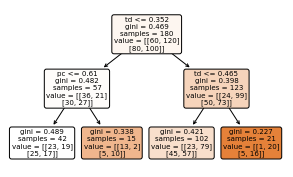

  1%|▍                                           | 1/92 [00:00<00:31,  2.90it/s]

1
Node_1
(42, 19)
(16, 19)
LR Model
16
16
Node_2
(15, 19)
(3, 19)
LR Model
19
19
Node_3
(102, 19)
(67, 19)
LR Model
86
86
Node_4
(21, 19)
(4, 19)
LR Model
90
90
588458
Assay:  588334
Inactive Compounds  316
Active Compounds  106
Inactive Compounds (after Undersamplimg)  106
Total Compounds (after Undersamplimg)  212
212
106
Herirachal model for training data


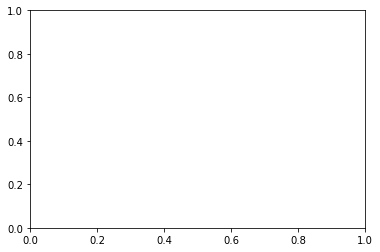

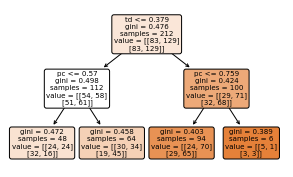

  2%|▉                                           | 2/92 [00:00<00:34,  2.63it/s]

2
Node_1
(48, 19)
(10, 19)
LR Model
10
10
Node_2
(64, 19)
(37, 19)
LR Model
47
47
Node_3
(94, 19)
(51, 19)
LR Model
98
98
Node_4
(6, 19)
(8, 19)
only negative variables in train but test compounds present, take average:
588334
Assay:  2642
Inactive Compounds  458
Active Compounds  153
Inactive Compounds (after Undersamplimg)  153
Total Compounds (after Undersamplimg)  306
306
153
Herirachal model for training data


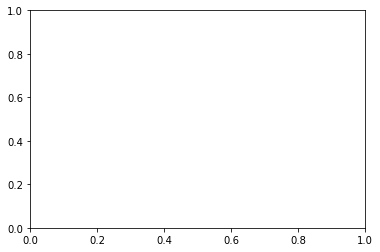

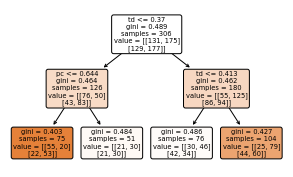

  3%|█▍                                          | 3/92 [00:01<00:35,  2.53it/s]

3
Node_1
(75, 19)
(18, 19)
LR Model
18
18
Node_2
(51, 19)
(18, 19)
LR Model
36
36
Node_3
(76, 19)
(40, 19)
LR Model
76
76
Node_4
(104, 19)
(77, 19)
LR Model
153
153
2642
Assay:  2156
Inactive Compounds  340
Active Compounds  114
Inactive Compounds (after Undersamplimg)  114
Total Compounds (after Undersamplimg)  228
228
114
Herirachal model for training data


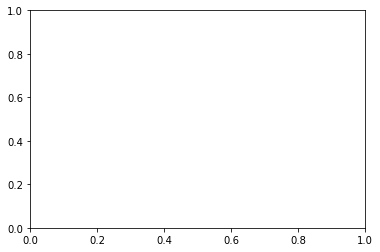

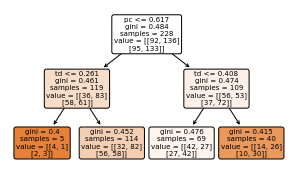

  4%|█▉                                          | 4/92 [00:01<00:35,  2.49it/s]

4
Node_1
(5, 19)
(0, 19)
Node_2
(114, 19)
(46, 19)
LR Model
46
46
Node_3
(69, 19)
(41, 19)
LR Model
87
87
Node_4
(40, 19)
(27, 19)
LR Model
114
114
2156
Assay:  2330
Inactive Compounds  196
Active Compounds  66
Inactive Compounds (after Undersamplimg)  66
Total Compounds (after Undersamplimg)  132
132
66
Herirachal model for training data


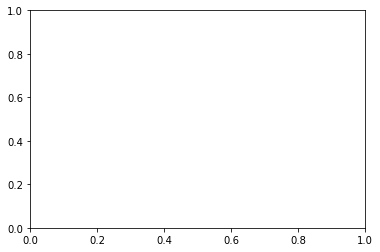

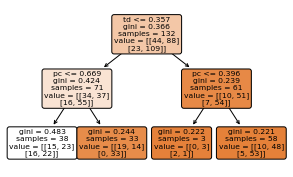

  5%|██▍                                         | 5/92 [00:01<00:34,  2.50it/s]

5
Node_1
(38, 19)
(20, 19)
LR Model
20
20
Node_2
(33, 19)
(9, 19)
LR Model
29
29
Node_3
(3, 19)
(3, 19)
LR Model
32
32
Node_4
(58, 19)
(34, 19)
LR Model
66
66
2330
Assay:  2216
Inactive Compounds  355
Active Compounds  118
Inactive Compounds (after Undersamplimg)  118
Total Compounds (after Undersamplimg)  236
236
119
Herirachal model for training data


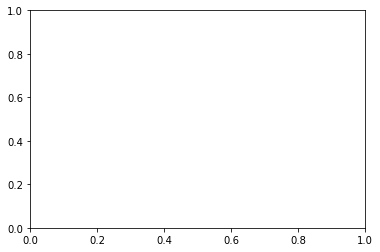

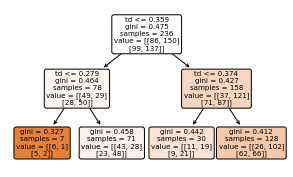

  7%|██▊                                         | 6/92 [00:02<00:33,  2.54it/s]

6
Node_1
(7, 19)
(3, 19)
LR Model
3
3
Node_2
(71, 19)
(22, 19)
LR Model
25
25
Node_3
(30, 19)
(10, 19)
LR Model
35
35
Node_4
(128, 19)
(84, 19)
LR Model
119
119
2216
Assay:  743015
Inactive Compounds  172
Active Compounds  110
Inactive Compounds (after Undersamplimg)  110
Total Compounds (after Undersamplimg)  220
220
71
Herirachal model for training data


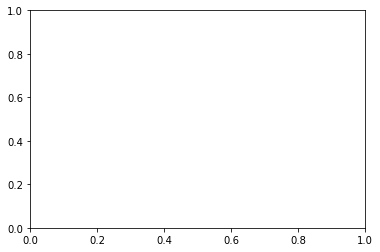

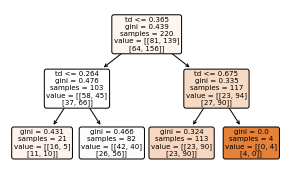

  8%|███▎                                        | 7/92 [00:02<00:35,  2.42it/s]

7
Node_1
(21, 19)
(3, 19)
LR Model
3
3
Node_2
(82, 19)
(28, 19)
LR Model
31
31
Node_3
(113, 19)
(40, 19)
LR Model
71
71
Node_4
(4, 19)
(0, 19)
71
71
743015
Assay:  504444
Inactive Compounds  645
Active Compounds  215
Inactive Compounds (after Undersamplimg)  215
Total Compounds (after Undersamplimg)  430
430
216
Herirachal model for training data


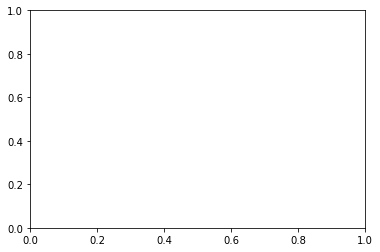

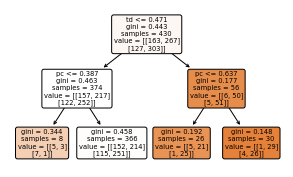

  9%|███▊                                        | 8/92 [00:03<00:34,  2.45it/s]

8
Node_1
(8, 19)
(2, 19)
LR Model
2
2
Node_2
(366, 19)
(166, 19)
LR Model
168
168
Node_3
(26, 19)
(23, 19)
LR Model
191
191
Node_4
(30, 19)
(25, 19)
LR Model
216
216
504444
Assay:  894
Inactive Compounds  693
Active Compounds  231
Inactive Compounds (after Undersamplimg)  231
Total Compounds (after Undersamplimg)  462
462
232
Herirachal model for training data


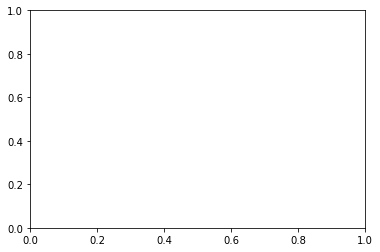

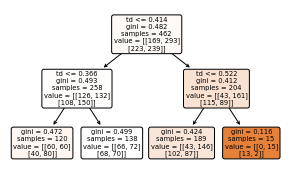

 10%|████▎                                       | 9/92 [00:03<00:33,  2.46it/s]

9
Node_1
(120, 19)
(42, 19)
LR Model
42
42
Node_2
(138, 19)
(61, 19)
LR Model
103
103
Node_3
(189, 19)
(112, 19)
LR Model
215
215
Node_4
(15, 19)
(17, 19)
LR Model
232
232
894
Assay:  720635
Inactive Compounds  140
Active Compounds  64
Inactive Compounds (after Undersamplimg)  64
Total Compounds (after Undersamplimg)  128
128
51
Herirachal model for training data


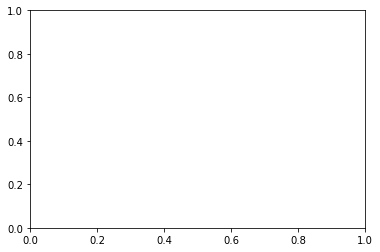

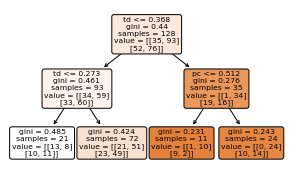

 11%|████▋                                      | 10/92 [00:03<00:32,  2.49it/s]

10
Node_1
(21, 19)
(4, 19)
LR Model
4
4
Node_2
(72, 19)
(28, 19)
LR Model
32
32
Node_3
(11, 19)
(3, 19)
LR Model
35
35
Node_4
(24, 19)
(16, 19)
LR Model
51
51
720635
Assay:  1688
Inactive Compounds  364
Active Compounds  122
Inactive Compounds (after Undersamplimg)  122
Total Compounds (after Undersamplimg)  244
244
122
Herirachal model for training data


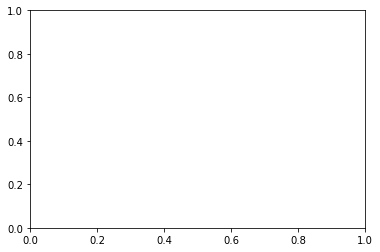

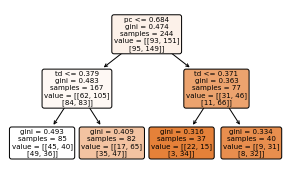

 12%|█████▏                                     | 11/92 [00:04<00:32,  2.47it/s]

11
Node_1
(85, 19)
(32, 19)
LR Model
32
32
Node_2
(82, 19)
(48, 19)
LR Model
80
80
Node_3
(37, 19)
(12, 19)
LR Model
92
92
Node_4
(40, 19)
(30, 19)
LR Model
122
122
1688
Assay:  2599
Inactive Compounds  540
Active Compounds  180
Inactive Compounds (after Undersamplimg)  180
Total Compounds (after Undersamplimg)  360
360
180
Herirachal model for training data


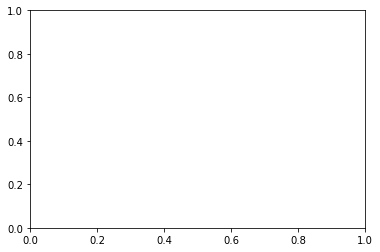

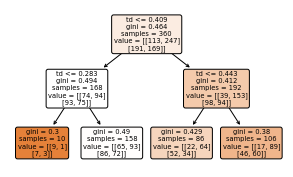

 13%|█████▌                                     | 12/92 [00:04<00:32,  2.43it/s]

12
Node_1
(10, 19)
(2, 19)
LR Model
2
2
Node_2
(158, 19)
(73, 19)
LR Model
75
75
Node_3
(86, 19)
(45, 19)
LR Model
120
120
Node_4
(106, 19)
(60, 19)
LR Model
180
180
2599
Assay:  602340
Inactive Compounds  180
Active Compounds  60
Inactive Compounds (after Undersamplimg)  60
Total Compounds (after Undersamplimg)  120
120
60
Herirachal model for training data


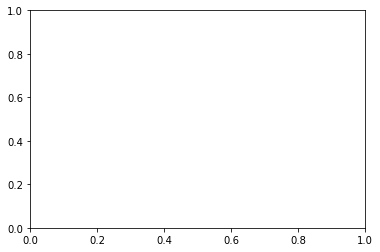

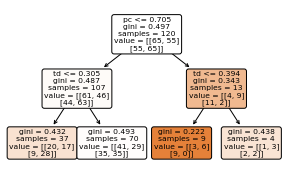

 14%|██████                                     | 13/92 [00:05<00:32,  2.43it/s]

13
Node_1
(37, 19)
(8, 19)
LR Model
8
8
Node_2
(70, 19)
(44, 19)
LR Model
52
52
Node_3
(9, 19)
(4, 19)
LR Model
56
56
Node_4
(4, 19)
(4, 19)
only negative variables in train but test compounds present, take average:
602340
Assay:  2796
Inactive Compounds  808
Active Compounds  270
Inactive Compounds (after Undersamplimg)  270
Total Compounds (after Undersamplimg)  540
540
270
Herirachal model for training data


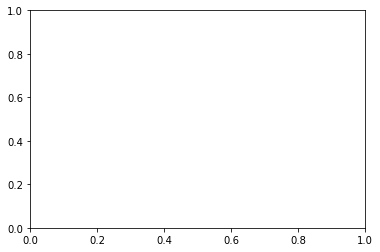

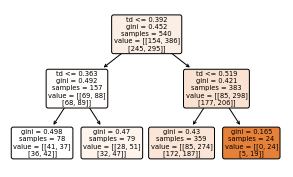

 15%|██████▌                                    | 14/92 [00:05<00:34,  2.29it/s]

14
Node_1
(78, 19)
(20, 19)
LR Model
20
20
Node_2
(79, 19)
(19, 19)
LR Model
39
39
Node_3
(359, 19)
(205, 19)
LR Model
244
244
Node_4
(24, 19)
(26, 19)
LR Model
270
270
2796
Assay:  504652
Inactive Compounds  705
Active Compounds  235
Inactive Compounds (after Undersamplimg)  235
Total Compounds (after Undersamplimg)  470
470
236
Herirachal model for training data


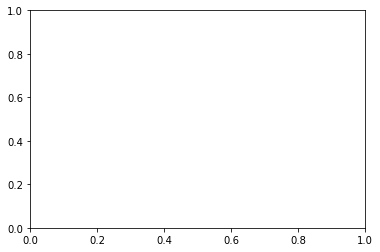

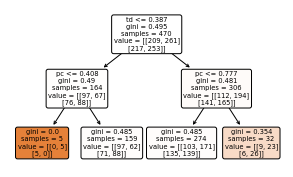

 16%|███████                                    | 15/92 [00:06<00:33,  2.32it/s]

15
Node_1
(5, 19)
(0, 19)
Node_2
(159, 19)
(53, 19)
LR Model
53
53
Node_3
(274, 19)
(163, 19)
LR Model
216
216
Node_4
(32, 19)
(20, 19)
LR Model
236
236
504652
Assay:  651658
Inactive Compounds  230
Active Compounds  77
Inactive Compounds (after Undersamplimg)  77
Total Compounds (after Undersamplimg)  154
154
77
Herirachal model for training data


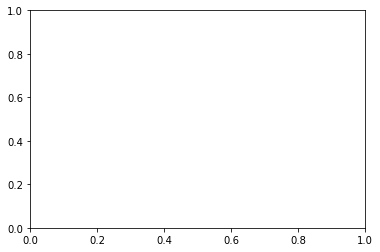

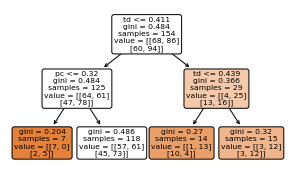

 17%|███████▍                                   | 16/92 [00:06<00:32,  2.35it/s]

16
Node_1
(7, 19)
(1, 19)
LR Model
1
1
Node_2
(118, 19)
(59, 19)
LR Model
60
60
Node_3
(14, 19)
(6, 19)
LR Model
66
66
Node_4
(15, 19)
(11, 19)
LR Model
77
77
651658
Assay:  720582
Inactive Compounds  278
Active Compounds  93
Inactive Compounds (after Undersamplimg)  93
Total Compounds (after Undersamplimg)  186
186
93
Herirachal model for training data


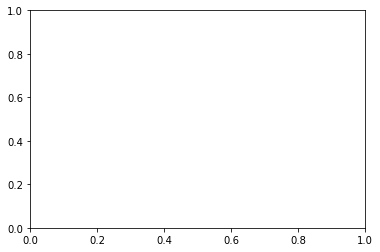

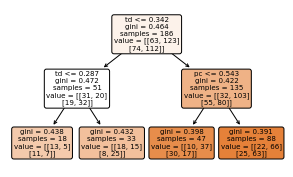

 18%|███████▉                                   | 17/92 [00:06<00:31,  2.37it/s]

17
Node_1
(18, 19)
(0, 19)
Node_2
(33, 19)
(11, 19)
LR Model
11
11
Node_3
(47, 19)
(33, 19)
LR Model
44
44
Node_4
(88, 19)
(49, 19)
LR Model
93
93
720582
Assay:  624256
Inactive Compounds  300
Active Compounds  100
Inactive Compounds (after Undersamplimg)  100
Total Compounds (after Undersamplimg)  200
200
100
Herirachal model for training data


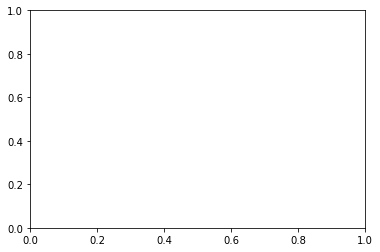

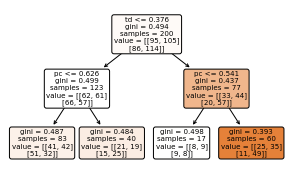

 20%|████████▍                                  | 18/92 [00:07<00:30,  2.40it/s]

18
Node_1
(83, 19)
(25, 19)
LR Model
25
25
Node_2
(40, 19)
(13, 19)
LR Model
38
38
Node_3
(17, 19)
(14, 19)
LR Model
52
52
Node_4
(60, 19)
(48, 19)
LR Model
100
100
624256
Assay:  1531
Inactive Compounds  273
Active Compounds  91
Inactive Compounds (after Undersamplimg)  91
Total Compounds (after Undersamplimg)  182
182
92
Herirachal model for training data


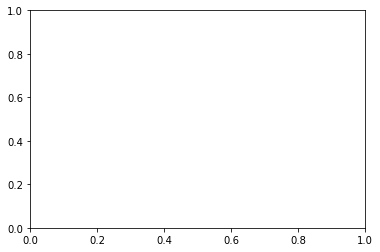

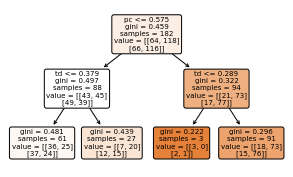

 21%|████████▉                                  | 19/92 [00:07<00:30,  2.42it/s]

19
Node_1
(61, 19)
(16, 19)
LR Model
16
16
Node_2
(27, 19)
(18, 19)
LR Model
34
34
Node_3
(3, 19)
(2, 19)
only positive variables in train but test compounds present, take average:
Node_4
(91, 19)
(56, 19)
LR Model
92
92
1531
Assay:  588852
Inactive Compounds  295
Active Compounds  98
Inactive Compounds (after Undersamplimg)  98
Total Compounds (after Undersamplimg)  196
196
99
Herirachal model for training data


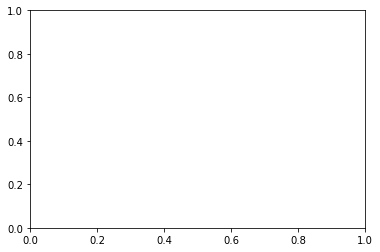

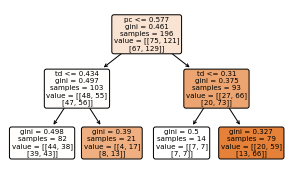

 22%|█████████▎                                 | 20/92 [00:08<00:29,  2.45it/s]

20
Node_1
(82, 19)
(34, 19)
LR Model
34
34
Node_2
(21, 19)
(5, 19)
LR Model
39
39
Node_3
(14, 19)
(2, 19)
LR Model
41
41
Node_4
(79, 19)
(58, 19)
LR Model
99
99
588852
Assay:  485270
Inactive Compounds  436
Active Compounds  146
Inactive Compounds (after Undersamplimg)  146
Total Compounds (after Undersamplimg)  292
292
146
Herirachal model for training data


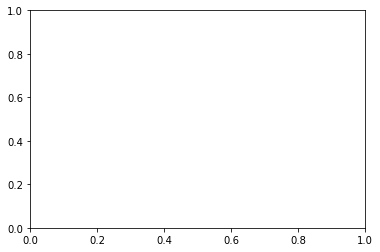

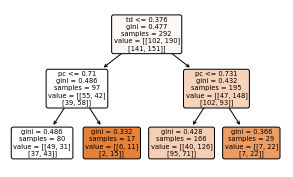

 23%|█████████▊                                 | 21/92 [00:08<00:30,  2.33it/s]

21
Node_1
(80, 19)
(21, 19)
LR Model
21
21
Node_2
(17, 19)
(13, 19)
LR Model
34
34
Node_3
(166, 19)
(90, 19)
LR Model
124
124
Node_4
(29, 19)
(22, 19)
LR Model
146
146
485270
Assay:  743012
Inactive Compounds  179
Active Compounds  110
Inactive Compounds (after Undersamplimg)  110
Total Compounds (after Undersamplimg)  220
220
73
Herirachal model for training data


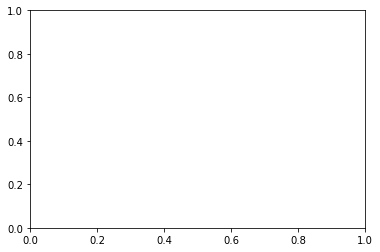

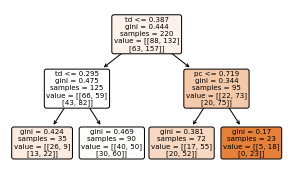

 24%|██████████▎                                | 22/92 [00:09<00:29,  2.37it/s]

22
Node_1
(35, 19)
(6, 19)
LR Model
6
6
Node_2
(90, 19)
(23, 19)
LR Model
29
29
Node_3
(72, 19)
(30, 19)
LR Model
59
59
Node_4
(23, 19)
(14, 19)
LR Model
73
73
743012
Assay:  777
Inactive Compounds  2049
Active Compounds  683
Inactive Compounds (after Undersamplimg)  683
Total Compounds (after Undersamplimg)  1366
1366
684
Herirachal model for training data


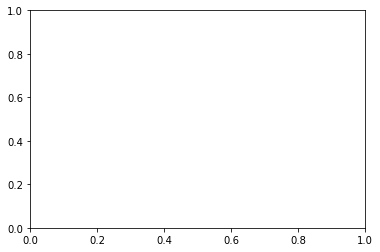

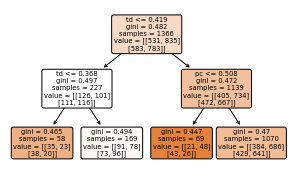

 25%|██████████▊                                | 23/92 [00:09<00:29,  2.38it/s]

23
Node_1
(58, 19)
(20, 19)
LR Model
20
20
Node_2
(169, 19)
(61, 19)
LR Model
81
81
Node_3
(69, 19)
(26, 19)
LR Model
107
107
Node_4
(1070, 19)
(577, 19)
LR Model
684
684
777
Assay:  504582
Inactive Compounds  247
Active Compounds  82
Inactive Compounds (after Undersamplimg)  82
Total Compounds (after Undersamplimg)  164
164
83
Herirachal model for training data


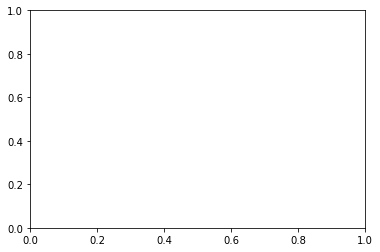

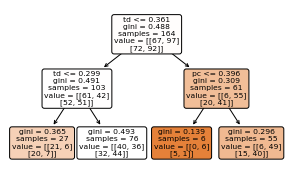

 26%|███████████▏                               | 24/92 [00:09<00:28,  2.43it/s]

24
Node_1
(27, 19)
(10, 19)
LR Model
10
10
Node_2
(76, 19)
(20, 19)
LR Model
30
30
Node_3
(6, 19)
(1, 19)
LR Model
31
31
Node_4
(55, 19)
(52, 19)
LR Model
83
83
504582
Assay:  504660
Inactive Compounds  297
Active Compounds  99
Inactive Compounds (after Undersamplimg)  99
Total Compounds (after Undersamplimg)  198
198
100
Herirachal model for training data


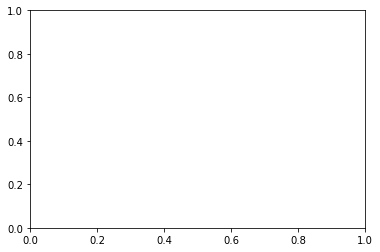

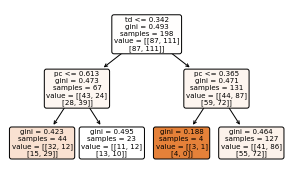

 27%|███████████▋                               | 25/92 [00:10<00:27,  2.48it/s]

25
Node_1
(44, 19)
(6, 19)
LR Model
6
6
Node_2
(23, 19)
(11, 19)
LR Model
17
17
Node_3
(4, 19)
(0, 19)
17
17
Node_4
(127, 19)
(83, 19)
LR Model
100
100
504660
Assay:  2553
Inactive Compounds  252
Active Compounds  84
Inactive Compounds (after Undersamplimg)  84
Total Compounds (after Undersamplimg)  168
168
84
Herirachal model for training data


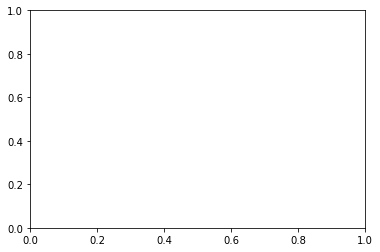

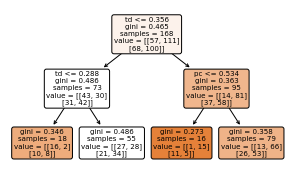

 28%|████████████▏                              | 26/92 [00:10<00:26,  2.51it/s]

26
Node_1
(18, 19)
(3, 19)
LR Model
3
3
Node_2
(55, 19)
(25, 19)
LR Model
28
28
Node_3
(16, 19)
(12, 19)
LR Model
40
40
Node_4
(79, 19)
(44, 19)
LR Model
84
84
2553
Assay:  743014
Inactive Compounds  175
Active Compounds  96
Inactive Compounds (after Undersamplimg)  96
Total Compounds (after Undersamplimg)  192
192
68
Herirachal model for training data


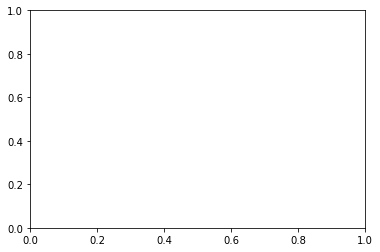

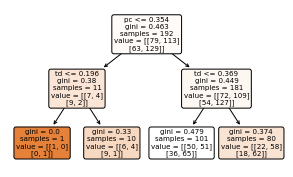

 29%|████████████▌                              | 27/92 [00:11<00:25,  2.53it/s]

27
Node_1
(1, 19)
(0, 19)
0
0
Node_2
(10, 19)
(1, 19)
only positive variables in train but test compounds present, take average:
Node_3
(101, 19)
(28, 19)
LR Model
29
29
Node_4
(80, 19)
(39, 19)
LR Model
68
68
743014
Assay:  1822
Inactive Compounds  324
Active Compounds  108
Inactive Compounds (after Undersamplimg)  108
Total Compounds (after Undersamplimg)  216
216
108
Herirachal model for training data


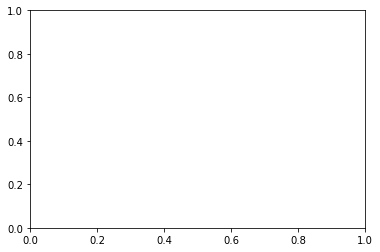

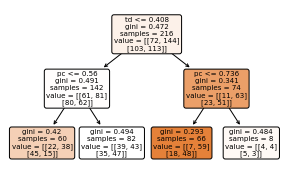

 30%|█████████████                              | 28/92 [00:11<00:26,  2.42it/s]

28
Node_1
(60, 19)
(22, 19)
LR Model
22
22
Node_2
(82, 19)
(37, 19)
LR Model
59
59
Node_3
(66, 19)
(40, 19)
LR Model
99
99
Node_4
(8, 19)
(9, 19)
only negative variables in train but test compounds present, take average:
1822
Assay:  938
Inactive Compounds  336
Active Compounds  112
Inactive Compounds (after Undersamplimg)  112
Total Compounds (after Undersamplimg)  224
224
112
Herirachal model for training data


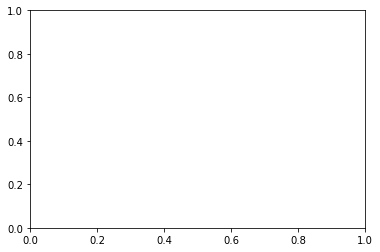

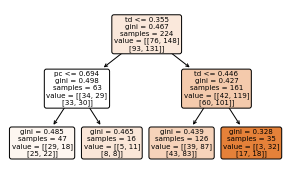

 32%|█████████████▌                             | 29/92 [00:11<00:25,  2.47it/s]

29
Node_1
(47, 19)
(13, 19)
LR Model
13
13
Node_2
(16, 19)
(6, 19)
LR Model
19
19
Node_3
(126, 19)
(63, 19)
LR Model
82
82
Node_4
(35, 19)
(30, 19)
LR Model
112
112
938
Assay:  1529
Inactive Compounds  350
Active Compounds  117
Inactive Compounds (after Undersamplimg)  117
Total Compounds (after Undersamplimg)  234
234
117
Herirachal model for training data


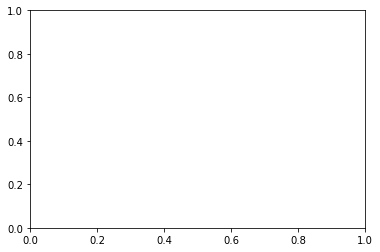

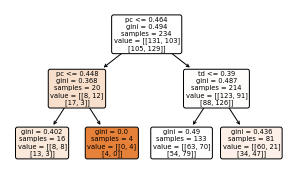

 33%|██████████████                             | 30/92 [00:12<00:24,  2.48it/s]

30
Node_1
(16, 19)
(6, 19)
LR Model
6
6
Node_2
(4, 19)
(0, 19)
Node_3
(133, 19)
(39, 19)
LR Model
45
45
Node_4
(81, 19)
(72, 19)
LR Model
117
117
1529
Assay:  651610
Inactive Compounds  357
Active Compounds  119
Inactive Compounds (after Undersamplimg)  119
Total Compounds (after Undersamplimg)  238
238
120
Herirachal model for training data


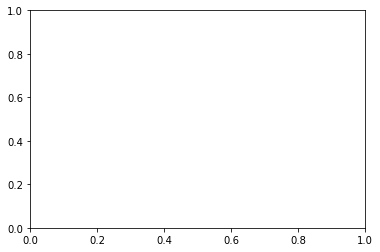

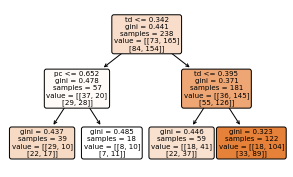

 34%|██████████████▍                            | 31/92 [00:12<00:24,  2.50it/s]

31
Node_1
(39, 19)
(11, 19)
LR Model
11
11
Node_2
(18, 19)
(9, 19)
LR Model
20
20
Node_3
(59, 19)
(32, 19)
LR Model
52
52
Node_4
(122, 19)
(68, 19)
LR Model
120
120
651610
Assay:  624466
Inactive Compounds  408
Active Compounds  136
Inactive Compounds (after Undersamplimg)  136
Total Compounds (after Undersamplimg)  272
272
136
Herirachal model for training data


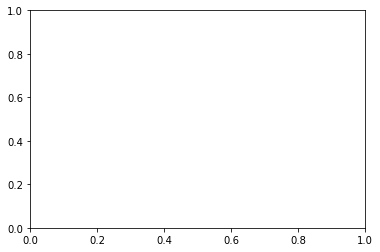

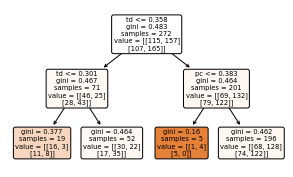

 35%|██████████████▉                            | 32/92 [00:13<00:23,  2.52it/s]

32
Node_1
(19, 19)
(8, 19)
LR Model
8
8
Node_2
(52, 19)
(20, 19)
LR Model
28
28
Node_3
(5, 19)
(0, 19)
Node_4
(196, 19)
(108, 19)
LR Model
136
136
624466
Assay:  932
Inactive Compounds  1005
Active Compounds  335
Inactive Compounds (after Undersamplimg)  335
Total Compounds (after Undersamplimg)  670
670
336
Herirachal model for training data


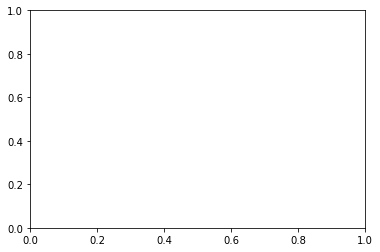

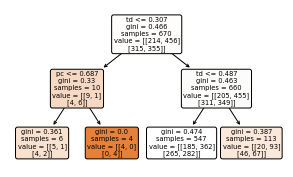

 36%|███████████████▍                           | 33/92 [00:13<00:23,  2.52it/s]

33
Node_1
(6, 19)
(1, 19)
LR Model
1
1
Node_2
(4, 19)
(1, 19)
LR Model
2
2
Node_3
(547, 19)
(246, 19)
LR Model
248
248
Node_4
(113, 19)
(88, 19)
LR Model
336
336
932
Assay:  720648
Inactive Compounds  283
Active Compounds  94
Inactive Compounds (after Undersamplimg)  94
Total Compounds (after Undersamplimg)  188
188
95
Herirachal model for training data


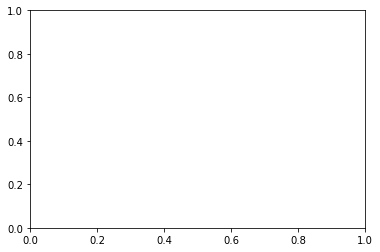

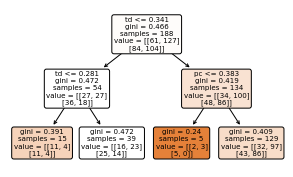

 37%|███████████████▉                           | 34/92 [00:13<00:23,  2.51it/s]

34
Node_1
(15, 19)
(4, 19)
LR Model
4
4
Node_2
(39, 19)
(16, 19)
LR Model
20
20
Node_3
(5, 19)
(4, 19)
LR Model
24
24
Node_4
(129, 19)
(71, 19)
LR Model
95
95
720648
Assay:  2540
Inactive Compounds  300
Active Compounds  100
Inactive Compounds (after Undersamplimg)  100
Total Compounds (after Undersamplimg)  200
200
100
Herirachal model for training data


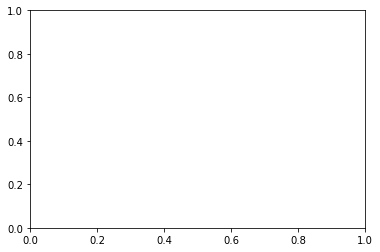

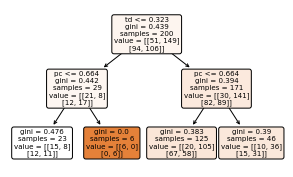

 38%|████████████████▎                          | 35/92 [00:14<00:23,  2.39it/s]

35
Node_1
(23, 19)
(10, 19)
LR Model
10
10
Node_2
(6, 19)
(1, 19)
LR Model
11
11
Node_3
(125, 19)
(58, 19)
LR Model
69
69
Node_4
(46, 19)
(31, 19)
LR Model
100
100
2540
Assay:  2098
Inactive Compounds  280
Active Compounds  94
Inactive Compounds (after Undersamplimg)  94
Total Compounds (after Undersamplimg)  188
188
94
Herirachal model for training data


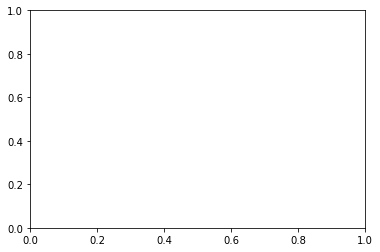

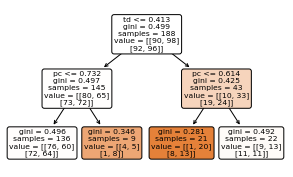

 39%|████████████████▊                          | 36/92 [00:14<00:23,  2.43it/s]

36
Node_1
(136, 19)
(55, 19)
LR Model
55
55
Node_2
(9, 19)
(10, 19)
LR Model
65
65
Node_3
(21, 19)
(12, 19)
LR Model
77
77
Node_4
(22, 19)
(17, 19)
LR Model
94
94
2098
Assay:  Novartis1
Inactive Compounds  66
Active Compounds  30
Inactive Compounds (after Undersamplimg)  30
Total Compounds (after Undersamplimg)  60
60
25
Herirachal model for training data


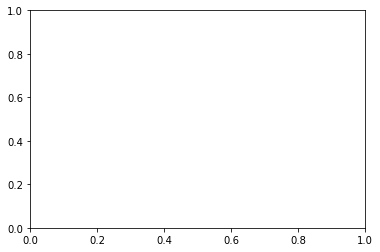

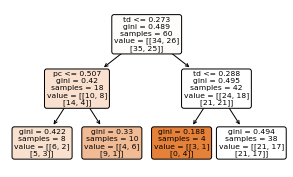

 40%|█████████████████▎                         | 37/92 [00:15<00:22,  2.46it/s]

37
Node_1
(8, 19)
(2, 19)
LR Model
2
2
Node_2
(10, 19)
(2, 19)
LR Model
4
4
Node_3
(4, 19)
(1, 19)
LR Model
5
5
Node_4
(38, 19)
(20, 19)
LR Model
25
25
Novartis1
Assay:  Novartis2
Inactive Compounds  65
Active Compounds  38
Inactive Compounds (after Undersamplimg)  38
Total Compounds (after Undersamplimg)  76
76
26
Herirachal model for training data


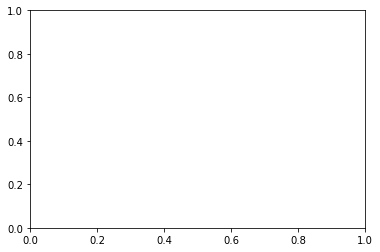

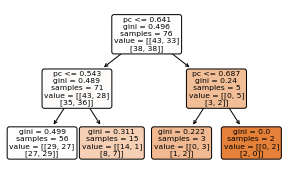

 41%|█████████████████▊                         | 38/92 [00:15<00:21,  2.50it/s]

38
Node_1
(56, 19)
(17, 19)
LR Model
17
17
Node_2
(15, 19)
(6, 19)
LR Model
23
23
Node_3
(3, 19)
(1, 19)
LR Model
24
24
Node_4
(2, 19)
(2, 19)
only negative variables in train but test compounds present, take average:
Novartis2
Assay:  2685
Inactive Compounds  91
Active Compounds  30
Inactive Compounds (after Undersamplimg)  30
Total Compounds (after Undersamplimg)  60
60
31
Herirachal model for training data


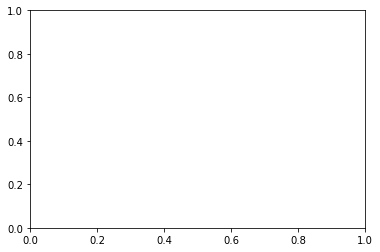

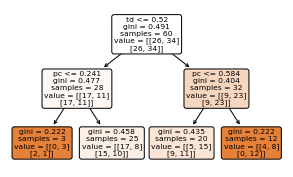

 42%|██████████████████▏                        | 39/92 [00:15<00:21,  2.49it/s]

39
Node_1
(3, 19)
(0, 19)
0
0
Node_2
(25, 19)
(11, 19)
LR Model
11
11
Node_3
(20, 19)
(11, 19)
LR Model
22
22
Node_4
(12, 19)
(9, 19)
LR Model
31
31
2685
Assay:  485294
Inactive Compounds  65
Active Compounds  26
Inactive Compounds (after Undersamplimg)  26
Total Compounds (after Undersamplimg)  52
52
23
Herirachal model for training data


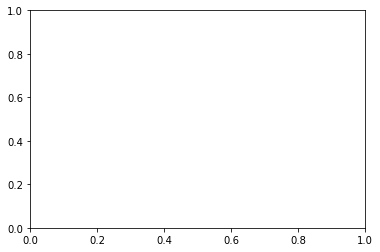

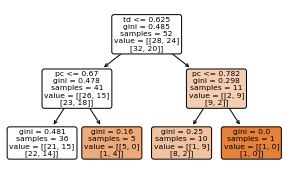

 43%|██████████████████▋                        | 40/92 [00:16<00:20,  2.51it/s]

40
Node_1
(36, 19)
(14, 19)
LR Model
14
14
Node_2
(5, 19)
(2, 19)
LR Model
16
16
Node_3
(10, 19)
(7, 19)
LR Model
23
23
Node_4
(1, 19)
(0, 19)
23
23
485294
Assay:  2517
Inactive Compounds  163
Active Compounds  54
Inactive Compounds (after Undersamplimg)  54
Total Compounds (after Undersamplimg)  108
108
55
Herirachal model for training data


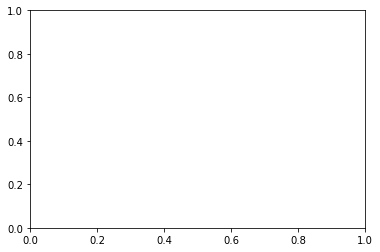

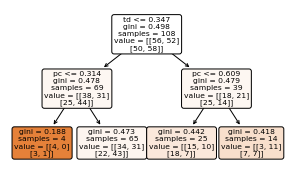

 45%|███████████████████▏                       | 41/92 [00:16<00:20,  2.54it/s]

41
Node_1
(4, 19)
(0, 19)
0
0
Node_2
(65, 19)
(21, 19)
LR Model
21
21
Node_3
(25, 19)
(21, 19)
LR Model
42
42
Node_4
(14, 19)
(13, 19)
LR Model
55
55
2517
Assay:  504333
Inactive Compounds  264
Active Compounds  478
Active Compounds (after Undersamplimg)  264
Total Compounds (after Undersamplimg)  528
528
186
Herirachal model for training data


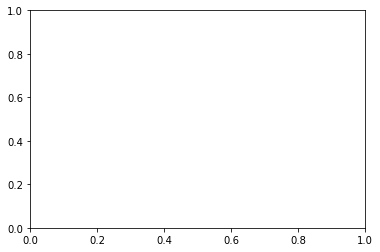

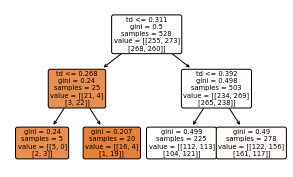

 46%|███████████████████▋                       | 42/92 [00:17<00:20,  2.41it/s]

42
Node_1
(5, 19)
(1, 19)
LR Model
1
1
Node_2
(20, 19)
(8, 19)
LR Model
9
9
Node_3
(225, 19)
(55, 19)
LR Model
64
64
Node_4
(278, 19)
(122, 19)
LR Model
186
186
504333
Assay:  881
Inactive Compounds  160
Active Compounds  54
Inactive Compounds (after Undersamplimg)  54
Total Compounds (after Undersamplimg)  108
108
54
Herirachal model for training data


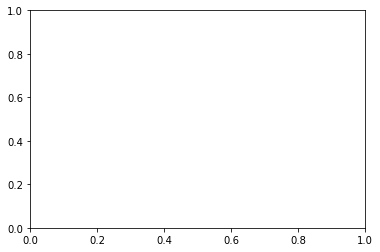

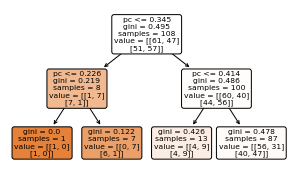

 47%|████████████████████                       | 43/92 [00:17<00:19,  2.48it/s]

43
Node_1
(1, 19)
(0, 19)
0
0
Node_2
(7, 19)
(6, 19)
only positive variables in train but test compounds present, take average:
Node_3
(13, 19)
(3, 19)
LR Model
9
9
Node_4
(87, 19)
(45, 19)
LR Model
54
54
881
Assay:  504339
Inactive Compounds  178
Active Compounds  466
Active Compounds (after Undersamplimg)  178
Total Compounds (after Undersamplimg)  356
356
161
Herirachal model for training data


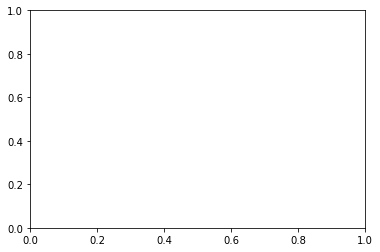

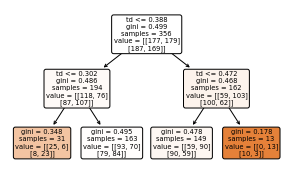

 48%|████████████████████▌                      | 44/92 [00:17<00:19,  2.44it/s]

44
Node_1
(31, 19)
(9, 19)
LR Model
9
9
Node_2
(163, 19)
(51, 19)
LR Model
60
60
Node_3
(149, 19)
(83, 19)
LR Model
143
143
Node_4
(13, 19)
(18, 19)
LR Model
161
161
504339
Assay:  504466
Inactive Compounds  58
Active Compounds  175
Active Compounds (after Undersamplimg)  58
Total Compounds (after Undersamplimg)  116
116
59
Herirachal model for training data


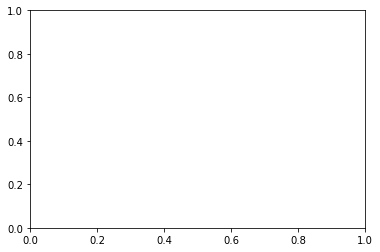

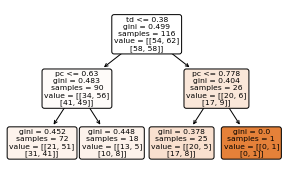

 49%|█████████████████████                      | 45/92 [00:18<00:19,  2.47it/s]

45
Node_1
(72, 19)
(22, 19)
LR Model
22
22
Node_2
(18, 19)
(9, 19)
LR Model
31
31
Node_3
(25, 19)
(25, 19)
LR Model
56
56
Node_4
(1, 19)
(3, 19)
only positive variables in train but test compounds present, take average:
504466
Assay:  504332
Inactive Compounds  326
Active Compounds  979
Active Compounds (after Undersamplimg)  326
Total Compounds (after Undersamplimg)  652
652
327
Herirachal model for training data


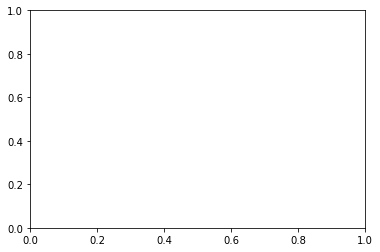

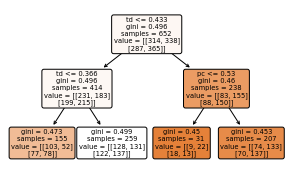

 50%|█████████████████████▌                     | 46/92 [00:18<00:18,  2.47it/s]

46
Node_1
(155, 19)
(32, 19)
LR Model
32
32
Node_2
(259, 19)
(103, 19)
LR Model
135
135
Node_3
(31, 19)
(24, 19)
LR Model
159
159
Node_4
(207, 19)
(168, 19)
LR Model
327
327
504332
Assay:  504327
Inactive Compounds  79
Active Compounds  45
Inactive Compounds (after Undersamplimg)  45
Total Compounds (after Undersamplimg)  90
90
31
Herirachal model for training data


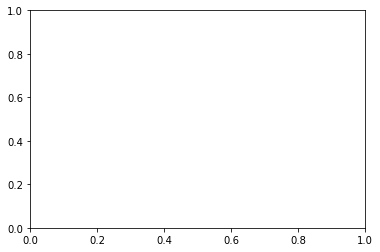

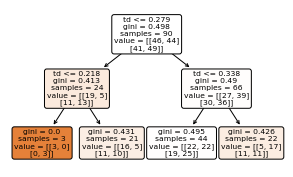

 51%|█████████████████████▉                     | 47/92 [00:19<00:17,  2.51it/s]

47
Node_1
(3, 19)
(0, 19)
0
0
Node_2
(21, 19)
(7, 19)
LR Model
7
7
Node_3
(44, 19)
(12, 19)
LR Model
19
19
Node_4
(22, 19)
(12, 19)
LR Model
31
31
504327
Assay:  488953
Inactive Compounds  42
Active Compounds  58
Active Compounds (after Undersamplimg)  42
Total Compounds (after Undersamplimg)  84
84
25
Herirachal model for training data


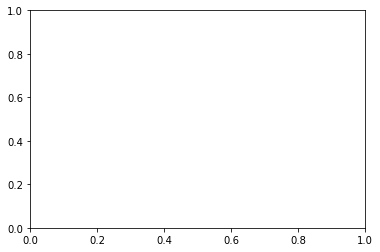

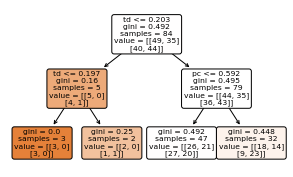

 52%|██████████████████████▍                    | 48/92 [00:19<00:17,  2.53it/s]

48
Node_1
(3, 19)
(2, 19)
LR Model
2
2
Node_2
(2, 19)
(0, 19)
2
2
Node_3
(47, 19)
(8, 19)
LR Model
10
10
Node_4
(32, 19)
(15, 19)
LR Model
25
25
488953
Assay:  1851_2
Inactive Compounds  471
Active Compounds  188
Inactive Compounds (after Undersamplimg)  188
Total Compounds (after Undersamplimg)  376
376
165
Herirachal model for training data


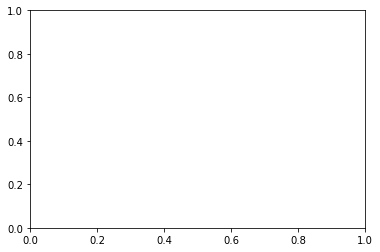

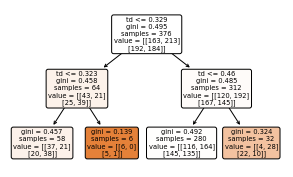

 53%|██████████████████████▉                    | 49/92 [00:19<00:17,  2.41it/s]

49
Node_1
(58, 19)
(17, 19)
LR Model
17
17
Node_2
(6, 19)
(1, 19)
only positive variables in train but test compounds present, take average:
Node_3
(280, 19)
(128, 19)
LR Model
146
146
Node_4
(32, 19)
(19, 19)
LR Model
165
165
1851_2
Assay:  1851_4
Inactive Compounds  270
Active Compounds  339
Active Compounds (after Undersamplimg)  270
Total Compounds (after Undersamplimg)  540
540
153
Herirachal model for training data


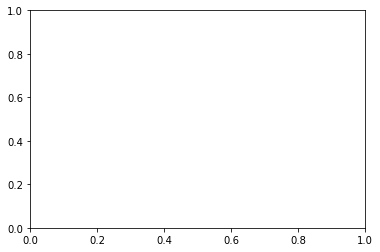

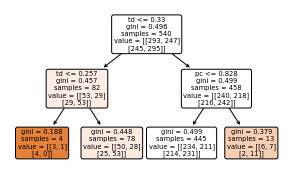

 54%|███████████████████████▎                   | 50/92 [00:20<00:17,  2.42it/s]

50
Node_1
(4, 19)
(1, 19)
LR Model
1
1
Node_2
(78, 19)
(11, 19)
LR Model
12
12
Node_3
(445, 19)
(140, 19)
LR Model
152
152
Node_4
(13, 19)
(1, 19)
LR Model
153
153
1851_4
Assay:  1851_1
Inactive Compounds  396
Active Compounds  268
Inactive Compounds (after Undersamplimg)  268
Total Compounds (after Undersamplimg)  536
536
166
Herirachal model for training data


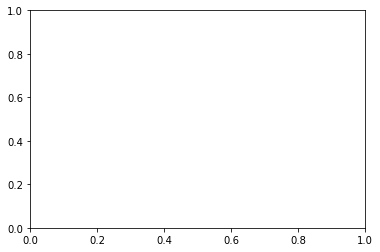

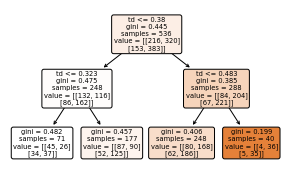

 55%|███████████████████████▊                   | 51/92 [00:20<00:16,  2.43it/s]

51
Node_1
(71, 19)
(9, 19)
LR Model
9
9
Node_2
(177, 19)
(51, 19)
LR Model
60
60
Node_3
(248, 19)
(95, 19)
LR Model
155
155
Node_4
(40, 19)
(11, 19)
only negative variables in train but test compounds present, take average:
1851_1
Assay:  1851_3
Inactive Compounds  397
Active Compounds  220
Inactive Compounds (after Undersamplimg)  220
Total Compounds (after Undersamplimg)  440
440
155
Herirachal model for training data


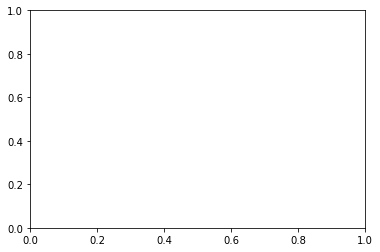

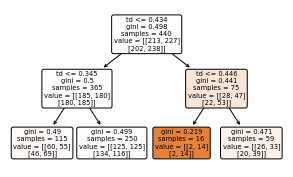

 57%|████████████████████████▎                  | 52/92 [00:21<00:16,  2.42it/s]

52
Node_1
(115, 19)
(31, 19)
LR Model
31
31
Node_2
(250, 19)
(96, 19)
LR Model
127
127
Node_3
(16, 19)
(7, 19)
LR Model
134
134
Node_4
(59, 19)
(21, 19)
LR Model
155
155
1851_3
Assay:  1851_5
Inactive Compounds  428
Active Compounds  204
Inactive Compounds (after Undersamplimg)  204
Total Compounds (after Undersamplimg)  408
408
158
Herirachal model for training data


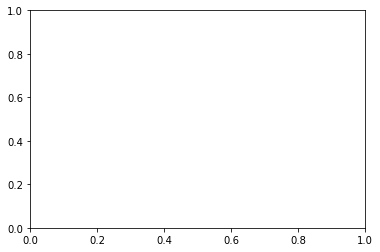

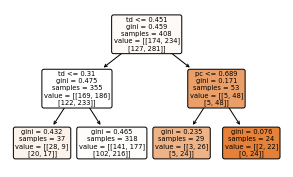

 58%|████████████████████████▊                  | 53/92 [00:21<00:16,  2.42it/s]

53
Node_1
(37, 19)
(6, 19)
LR Model
6
6
Node_2
(318, 19)
(118, 19)
LR Model
124
124
Node_3
(29, 19)
(16, 19)
LR Model
140
140
Node_4
(24, 19)
(18, 19)
LR Model
158
158
1851_5
Assay:  449750
Inactive Compounds  47
Active Compounds  79
Active Compounds (after Undersamplimg)  47
Total Compounds (after Undersamplimg)  94
94
32
Herirachal model for training data


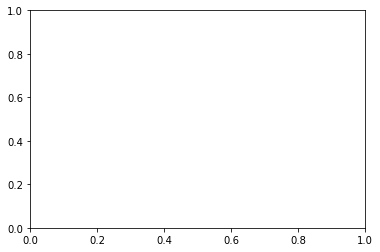

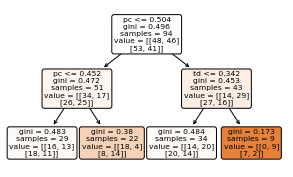

 59%|█████████████████████████▏                 | 54/92 [00:22<00:15,  2.43it/s]

54
Node_1
(29, 19)
(9, 19)
LR Model
9
9
Node_2
(22, 19)
(4, 19)
LR Model
13
13
Node_3
(34, 19)
(12, 19)
LR Model
25
25
Node_4
(9, 19)
(7, 19)
LR Model
32
32
449750
Assay:  504847
Inactive Compounds  75
Active Compounds  181
Active Compounds (after Undersamplimg)  75
Total Compounds (after Undersamplimg)  150
150
64
Herirachal model for training data


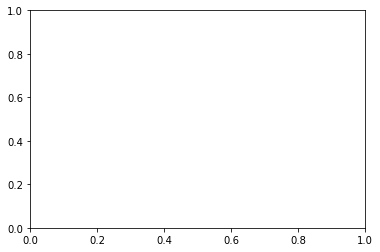

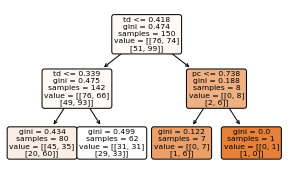

 60%|█████████████████████████▋                 | 55/92 [00:22<00:15,  2.45it/s]

55
Node_1
(80, 19)
(29, 19)
LR Model
29
29
Node_2
(62, 19)
(31, 19)
LR Model
60
60
Node_3
(7, 19)
(3, 19)
LR Model
63
63
Node_4
(1, 19)
(1, 19)
only positive variables in train but test compounds present, take average:
504847
Assay:  449749
Inactive Compounds  16
Active Compounds  48
Active Compounds (after Undersamplimg)  16
Total Compounds (after Undersamplimg)  32
32
16
Herirachal model for training data


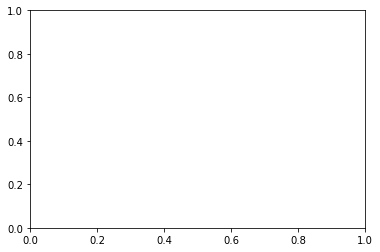

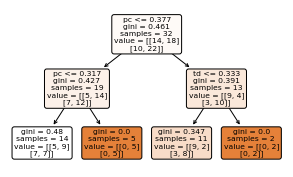

 61%|██████████████████████████▏                | 56/92 [00:22<00:15,  2.38it/s]

56
Node_1
(14, 19)
(2, 19)
LR Model
2
2
Node_2
(5, 19)
(2, 19)
only negative variables in train but test compounds present, take average:
Node_3
(11, 19)
(8, 19)
LR Model
12
12
Node_4
(2, 19)
(4, 19)
only positive variables in train but test compounds present, take average:
449749
Assay:  504834
Inactive Compounds  1533
Active Compounds  671
Inactive Compounds (after Undersamplimg)  671
Total Compounds (after Undersamplimg)  1342
1342
551
Herirachal model for training data


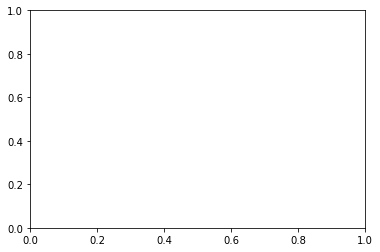

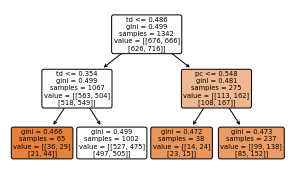

 62%|██████████████████████████▋                | 57/92 [00:23<00:14,  2.36it/s]

57
Node_1
(65, 19)
(18, 19)
LR Model
18
18
Node_2
(1002, 19)
(362, 19)
LR Model
380
380
Node_3
(38, 19)
(15, 19)
LR Model
395
395
Node_4
(237, 19)
(156, 19)
LR Model
551
551
504834
Assay:  540317
Inactive Compounds  187
Active Compounds  62
Inactive Compounds (after Undersamplimg)  62
Total Compounds (after Undersamplimg)  124
124
63
Herirachal model for training data


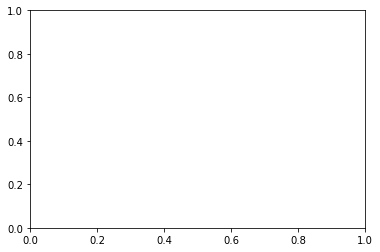

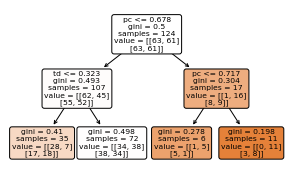

 63%|███████████████████████████                | 58/92 [00:23<00:14,  2.39it/s]

58
Node_1
(35, 19)
(11, 19)
LR Model
11
11
Node_2
(72, 19)
(36, 19)
LR Model
47
47
Node_3
(6, 19)
(7, 19)
only negative variables in train but test compounds present, take average:
Node_4
(11, 19)
(9, 19)
LR Model
63
63
540317
Assay:  588453
Inactive Compounds  416
Active Compounds  148
Inactive Compounds (after Undersamplimg)  148
Total Compounds (after Undersamplimg)  296
296
142
Herirachal model for training data


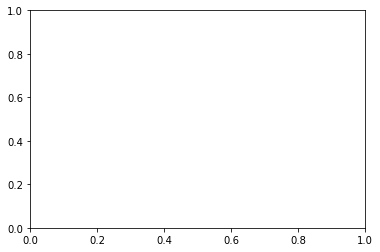

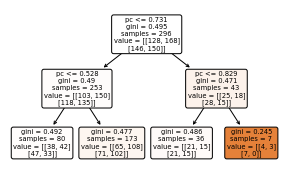

 64%|███████████████████████████▌               | 59/92 [00:24<00:13,  2.43it/s]

59
Node_1
(80, 19)
(25, 19)
LR Model
25
25
Node_2
(173, 19)
(89, 19)
LR Model
114
114
Node_3
(36, 19)
(25, 19)
LR Model
139
139
Node_4
(7, 19)
(3, 19)
only negative variables in train but test compounds present, take average:
588453
Assay:  588590
Inactive Compounds  408
Active Compounds  136
Inactive Compounds (after Undersamplimg)  136
Total Compounds (after Undersamplimg)  272
272
136
Herirachal model for training data


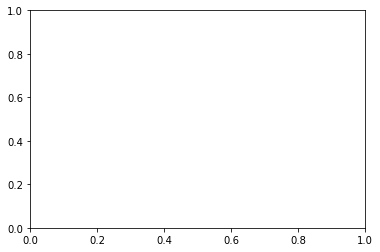

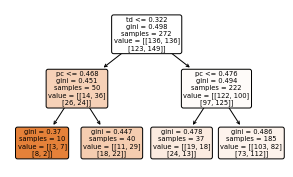

 65%|████████████████████████████               | 60/92 [00:24<00:13,  2.44it/s]

60
Node_1
(10, 19)
(2, 19)
only positive variables in train but test compounds present, take average:
Node_2
(40, 19)
(9, 19)
LR Model
11
11
Node_3
(37, 19)
(5, 19)
LR Model
16
16
Node_4
(185, 19)
(120, 19)
LR Model
136
136
588590
Assay:  588795
Inactive Compounds  44
Active Compounds  46
Active Compounds (after Undersamplimg)  44
Total Compounds (after Undersamplimg)  88
88
23
Herirachal model for training data


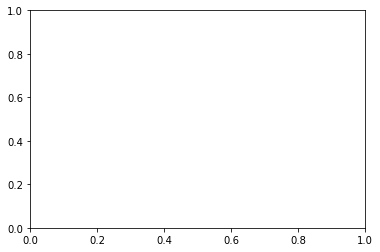

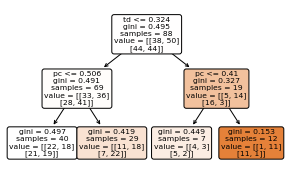

 66%|████████████████████████████▌              | 61/92 [00:24<00:12,  2.47it/s]

61
Node_1
(40, 19)
(7, 19)
LR Model
7
7
Node_2
(29, 19)
(10, 19)
LR Model
17
17
Node_3
(7, 19)
(1, 19)
LR Model
18
18
Node_4
(12, 19)
(5, 19)
LR Model
23
23
588795
Assay:  504845
Inactive Compounds  65
Active Compounds  35
Inactive Compounds (after Undersamplimg)  35
Total Compounds (after Undersamplimg)  70
70
26
Herirachal model for training data


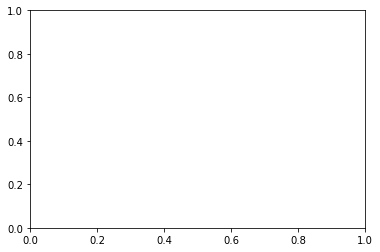

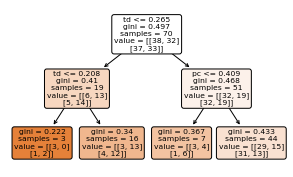

 67%|████████████████████████████▉              | 62/92 [00:25<00:12,  2.49it/s]

62
Node_1
(3, 19)
(1, 19)
LR Model
1
1
Node_2
(16, 19)
(4, 19)
LR Model
5
5
Node_3
(7, 19)
(5, 19)
LR Model
10
10
Node_4
(44, 19)
(16, 19)
LR Model
26
26
504845
Assay:  588579
Inactive Compounds  16
Active Compounds  48
Active Compounds (after Undersamplimg)  16
Total Compounds (after Undersamplimg)  32
32
16
Herirachal model for training data


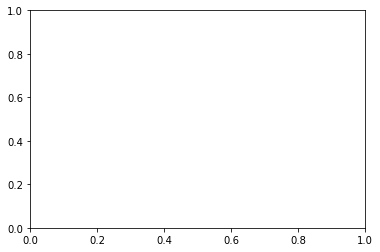

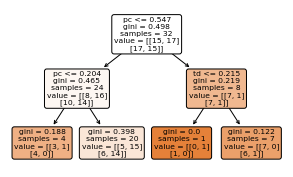

 68%|█████████████████████████████▍             | 63/92 [00:25<00:11,  2.42it/s]

63
Node_1
(4, 19)
(0, 19)
0
0
Node_2
(20, 19)
(8, 19)
LR Model
8
8
Node_3
(1, 19)
(1, 19)
only negative variables in train but test compounds present, take average:
Node_4
(7, 19)
(7, 19)
only positive variables in train but test compounds present, take average:
588579
Assay:  588856
Inactive Compounds  254
Active Compounds  85
Inactive Compounds (after Undersamplimg)  85
Total Compounds (after Undersamplimg)  170
170
85
Herirachal model for training data


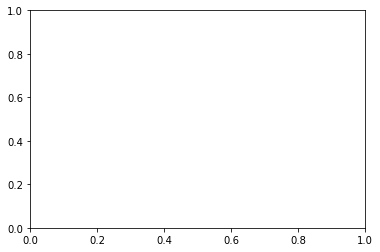

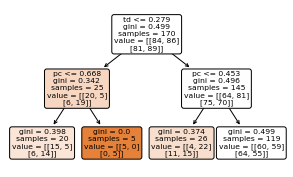

 70%|█████████████████████████████▉             | 64/92 [00:26<00:11,  2.47it/s]

64
Node_1
(20, 19)
(5, 19)
LR Model
5
5
Node_2
(5, 19)
(2, 19)
LR Model
7
7
Node_3
(26, 19)
(9, 19)
LR Model
16
16
Node_4
(119, 19)
(69, 19)
LR Model
85
85
588856
Assay:  504832
Inactive Compounds  1440
Active Compounds  666
Inactive Compounds (after Undersamplimg)  666
Total Compounds (after Undersamplimg)  1332
1332
527
Herirachal model for training data


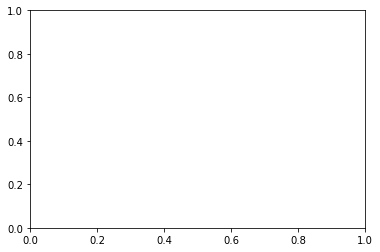

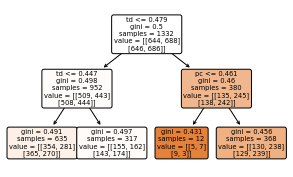

 71%|██████████████████████████████▍            | 65/92 [00:26<00:11,  2.44it/s]

65
Node_1
(635, 19)
(200, 19)
LR Model
200
200
Node_2
(317, 19)
(119, 19)
LR Model
319
319
Node_3
(12, 19)
(7, 19)
LR Model
326
326
Node_4
(368, 19)
(201, 19)
LR Model
527
527
504832
Assay:  588855
Inactive Compounds  170
Active Compounds  134
Inactive Compounds (after Undersamplimg)  134
Total Compounds (after Undersamplimg)  268
268
76
Herirachal model for training data


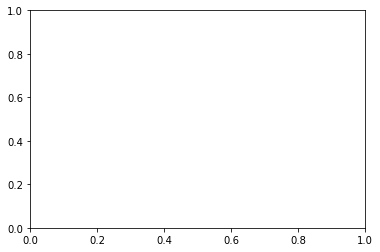

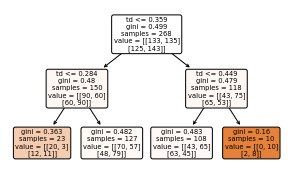

 72%|██████████████████████████████▊            | 66/92 [00:26<00:10,  2.48it/s]

66
Node_1
(23, 19)
(3, 19)
LR Model
3
3
Node_2
(127, 19)
(28, 19)
LR Model
31
31
Node_3
(108, 19)
(43, 19)
LR Model
74
74
Node_4
(10, 19)
(2, 19)
only negative variables in train but test compounds present, take average:
588855
Assay:  121
Inactive Compounds  60
Active Compounds  20
Inactive Compounds (after Undersamplimg)  20
Total Compounds (after Undersamplimg)  40
40
20
Herirachal model for training data


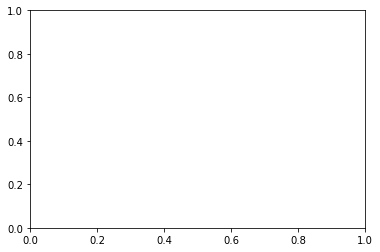

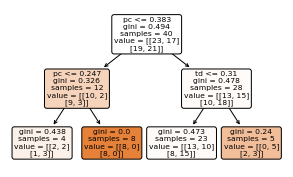

 73%|███████████████████████████████▎           | 67/92 [00:27<00:09,  2.52it/s]

67
Node_1
(4, 19)
(0, 19)
0
0
Node_2
(8, 19)
(2, 19)
LR Model
2
2
Node_3
(23, 19)
(16, 19)
LR Model
18
18
Node_4
(5, 19)
(2, 19)
only negative variables in train but test compounds present, take average:
121
Assay:  624032
Inactive Compounds  44
Active Compounds  41
Inactive Compounds (after Undersamplimg)  41
Total Compounds (after Undersamplimg)  82
82
22
Herirachal model for training data


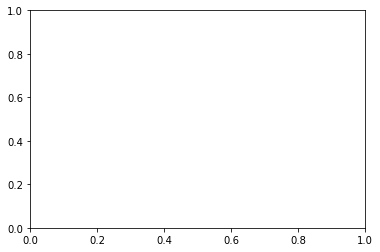

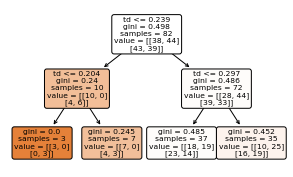

 74%|███████████████████████████████▊           | 68/92 [00:27<00:09,  2.53it/s]

68
Node_1
(3, 19)
(0, 19)
Node_2
(7, 19)
(5, 19)
LR Model
5
5
Node_3
(37, 19)
(7, 19)
LR Model
12
12
Node_4
(35, 19)
(10, 19)
LR Model
22
22
624032
Assay:  119
Inactive Compounds  62
Active Compounds  21
Inactive Compounds (after Undersamplimg)  21
Total Compounds (after Undersamplimg)  42
42
21
Herirachal model for training data


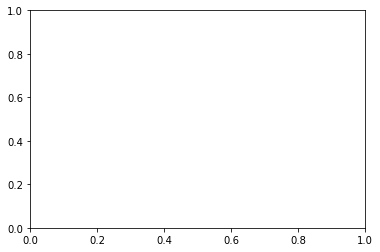

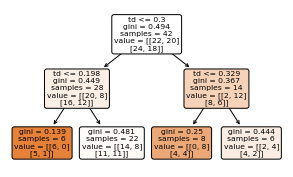

 75%|████████████████████████████████▎          | 69/92 [00:28<00:09,  2.52it/s]

69
Node_1
(6, 19)
(0, 19)
0
0
Node_2
(22, 19)
(9, 19)
LR Model
9
9
Node_3
(8, 19)
(3, 19)
LR Model
12
12
Node_4
(6, 19)
(9, 19)
only negative variables in train but test compounds present, take average:
119
Assay:  624296
Inactive Compounds  158
Active Compounds  410
Active Compounds (after Undersamplimg)  158
Total Compounds (after Undersamplimg)  316
316
142
Herirachal model for training data


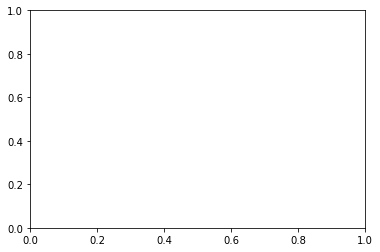

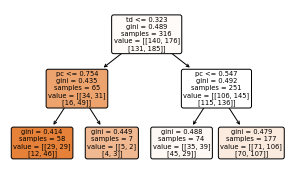

 76%|████████████████████████████████▋          | 70/92 [00:28<00:09,  2.39it/s]

70
Node_1
(58, 19)
(12, 19)
LR Model
12
12
Node_2
(7, 19)
(1, 19)
LR Model
13
13
Node_3
(74, 19)
(29, 19)
LR Model
42
42
Node_4
(177, 19)
(100, 19)
LR Model
142
142
624296
Assay:  651965
Inactive Compounds  90
Active Compounds  271
Active Compounds (after Undersamplimg)  90
Total Compounds (after Undersamplimg)  180
180
91
Herirachal model for training data


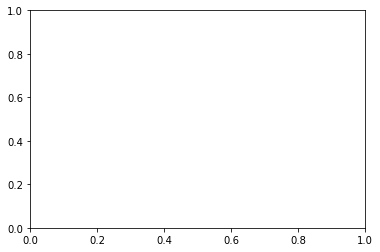

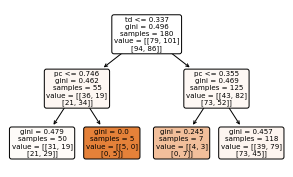

 77%|█████████████████████████████████▏         | 71/92 [00:29<00:08,  2.40it/s]

71
Node_1
(50, 19)
(23, 19)
LR Model
23
23
Node_2
(5, 19)
(2, 19)
only negative variables in train but test compounds present, take average:
Node_3
(7, 19)
(1, 19)
LR Model
26
26
Node_4
(118, 19)
(65, 19)
LR Model
91
91
651965
Assay:  624170
Inactive Compounds  91
Active Compounds  30
Inactive Compounds (after Undersamplimg)  30
Total Compounds (after Undersamplimg)  60
60
31
Herirachal model for training data


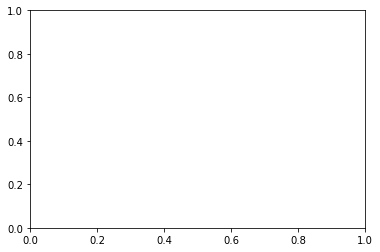

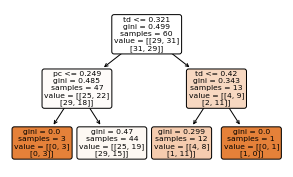

 78%|█████████████████████████████████▋         | 72/92 [00:29<00:08,  2.45it/s]

72
Node_1
(3, 19)
(0, 19)
0
0
Node_2
(44, 19)
(17, 19)
LR Model
17
17
Node_3
(12, 19)
(13, 19)
only negative variables in train but test compounds present, take average:
Node_4
(1, 19)
(1, 19)
only negative variables in train but test compounds present, take average:
624170
Assay:  651820
Inactive Compounds  65
Active Compounds  197
Active Compounds (after Undersamplimg)  65
Total Compounds (after Undersamplimg)  130
130
66
Herirachal model for training data


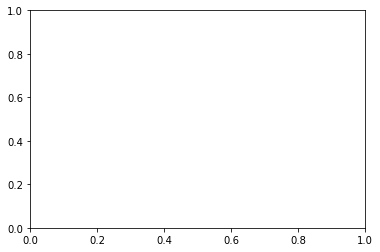

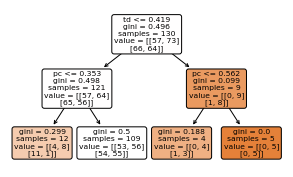

 79%|██████████████████████████████████         | 73/92 [00:29<00:07,  2.50it/s]

73
Node_1
(12, 19)
(1, 19)
only negative variables in train but test compounds present, take average:
Node_2
(109, 19)
(55, 19)
LR Model
56
56
Node_3
(4, 19)
(6, 19)
only positive variables in train but test compounds present, take average:
Node_4
(5, 19)
(4, 19)
only positive variables in train but test compounds present, take average:
651820
Assay:  624297
Inactive Compounds  386
Active Compounds  230
Inactive Compounds (after Undersamplimg)  230
Total Compounds (after Undersamplimg)  460
460
155
Herirachal model for training data


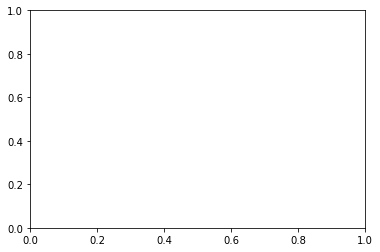

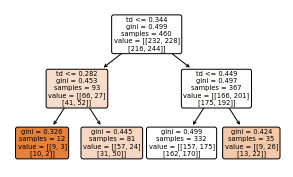

 80%|██████████████████████████████████▌        | 74/92 [00:30<00:07,  2.45it/s]

74
Node_1
(12, 19)
(3, 19)
LR Model
3
3
Node_2
(81, 19)
(22, 19)
LR Model
25
25
Node_3
(332, 19)
(105, 19)
LR Model
130
130
Node_4
(35, 19)
(25, 19)
LR Model
155
155
624297
Assay:  651635
Inactive Compounds  164
Active Compounds  119
Inactive Compounds (after Undersamplimg)  119
Total Compounds (after Undersamplimg)  238
238
71
Herirachal model for training data


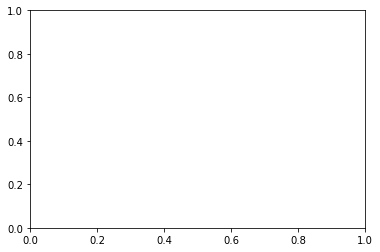

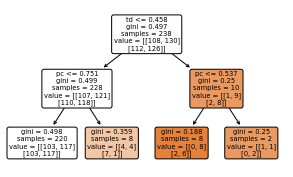

 82%|███████████████████████████████████        | 75/92 [00:30<00:06,  2.48it/s]

75
Node_1
(220, 19)
(65, 19)
LR Model
65
65
Node_2
(8, 19)
(4, 19)
LR Model
69
69
Node_3
(8, 19)
(0, 19)
Node_4
(2, 19)
(2, 19)
LR Model
71
71
651635
Assay:  624417
Inactive Compounds  495
Active Compounds  181
Inactive Compounds (after Undersamplimg)  181
Total Compounds (after Undersamplimg)  362
362
170
Herirachal model for training data


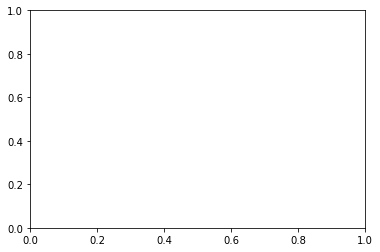

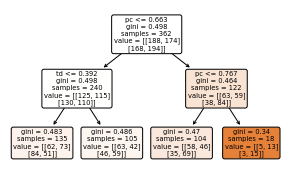

 83%|███████████████████████████████████▌       | 76/92 [00:30<00:06,  2.49it/s]

76
Node_1
(135, 19)
(43, 19)
LR Model
43
43
Node_2
(105, 19)
(56, 19)
LR Model
99
99
Node_3
(104, 19)
(55, 19)
LR Model
154
154
Node_4
(18, 19)
(16, 19)
LR Model
170
170
624417
Assay:  624202
Inactive Compounds  101
Active Compounds  202
Active Compounds (after Undersamplimg)  101
Total Compounds (after Undersamplimg)  202
202
76
Herirachal model for training data


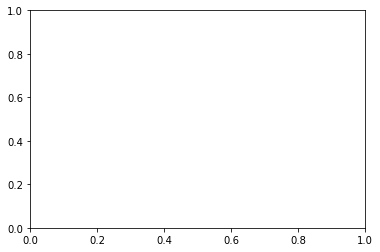

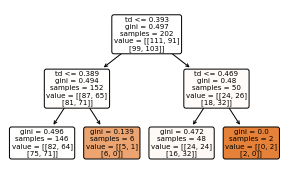

 84%|███████████████████████████████████▉       | 77/92 [00:31<00:06,  2.39it/s]

77
Node_1
(146, 19)
(48, 19)
LR Model
48
48
Node_2
(6, 19)
(1, 19)
LR Model
49
49
Node_3
(48, 19)
(26, 19)
LR Model
75
75
Node_4
(2, 19)
(1, 19)
only positive variables in train but test compounds present, take average:
624202
Assay:  624287
Inactive Compounds  62
Active Compounds  21
Inactive Compounds (after Undersamplimg)  21
Total Compounds (after Undersamplimg)  42
42
21
Herirachal model for training data


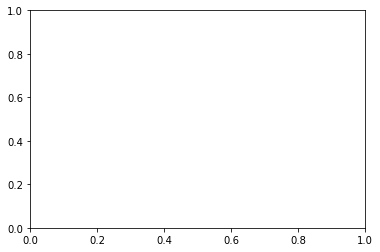

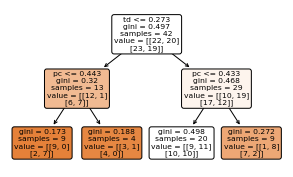

 85%|████████████████████████████████████▍      | 78/92 [00:31<00:05,  2.45it/s]

78
Node_1
(9, 19)
(3, 19)
LR Model
3
3
Node_2
(4, 19)
(4, 19)
LR Model
7
7
Node_3
(20, 19)
(3, 19)
LR Model
10
10
Node_4
(9, 19)
(11, 19)
LR Model
21
21
624287
Assay:  624288
Inactive Compounds  75
Active Compounds  49
Inactive Compounds (after Undersamplimg)  49
Total Compounds (after Undersamplimg)  98
98
31
Herirachal model for training data


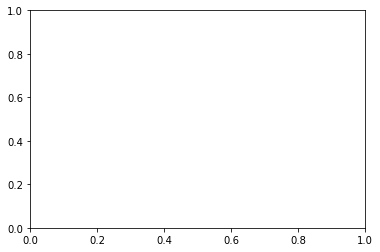

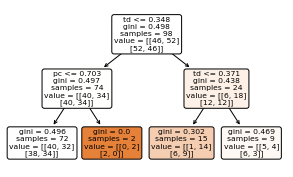

 86%|████████████████████████████████████▉      | 79/92 [00:32<00:05,  2.48it/s]

79
Node_1
(72, 19)
(22, 19)
LR Model
22
22
Node_2
(2, 19)
(1, 19)
only negative variables in train but test compounds present, take average:
Node_3
(15, 19)
(4, 19)
LR Model
27
27
Node_4
(9, 19)
(4, 19)
LR Model
31
31
624288
Assay:  651644
Inactive Compounds  91
Active Compounds  30
Inactive Compounds (after Undersamplimg)  30
Total Compounds (after Undersamplimg)  60
60
31
Herirachal model for training data


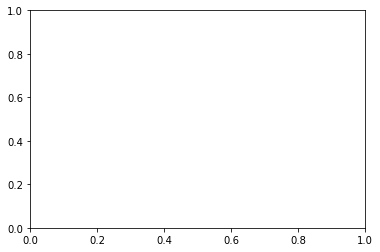

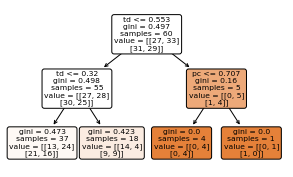

 87%|█████████████████████████████████████▍     | 80/92 [00:32<00:04,  2.53it/s]

80
Node_1
(37, 19)
(15, 19)
LR Model
15
15
Node_2
(18, 19)
(16, 19)
LR Model
31
31
Node_3
(4, 19)
(0, 19)
31
31
Node_4
(1, 19)
(0, 19)
31
31
651644
Assay:  686978
Inactive Compounds  9
Active Compounds  26
Active Compounds (after Undersamplimg)  9
Total Compounds (after Undersamplimg)  18
18
9
Herirachal model for training data


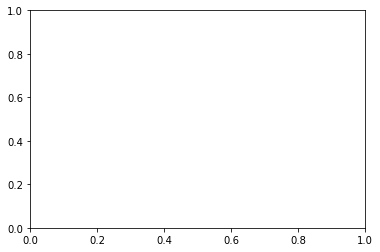

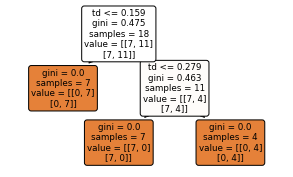

 88%|█████████████████████████████████████▊     | 81/92 [00:32<00:04,  2.70it/s]

81
Node_1
(7, 19)
(1, 19)
only negative variables in train but test compounds present, take average:
Node_2
(7, 19)
(5, 19)
LR Model
6
6
Node_3
(4, 19)
(3, 19)
only positive variables in train but test compounds present, take average:
Node_4
(0, 19)
(0, 19)
9
9
686978
Assay:  686979
Inactive Compounds  14
Active Compounds  43
Active Compounds (after Undersamplimg)  14
Total Compounds (after Undersamplimg)  28
28
15
Herirachal model for training data


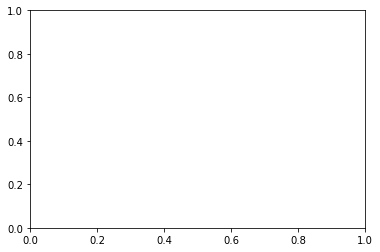

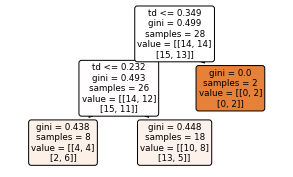

 89%|██████████████████████████████████████▎    | 82/92 [00:33<00:03,  2.78it/s]

82
Node_1
(8, 19)
(4, 19)
LR Model
4
4
Node_2
(18, 19)
(10, 19)
LR Model
14
14
Node_3
(2, 19)
(1, 19)
only positive variables in train but test compounds present, take average:
Node_4
(0, 19)
(0, 19)
15
15
686979
Assay:  652104
Inactive Compounds  124
Active Compounds  191
Active Compounds (after Undersamplimg)  124
Total Compounds (after Undersamplimg)  248
248
79
Herirachal model for training data


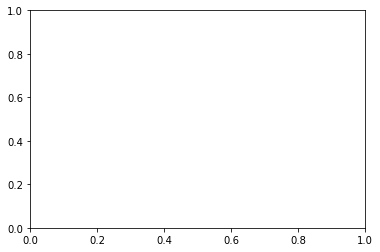

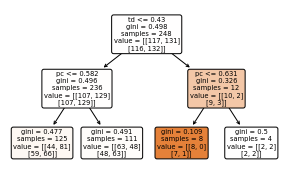

 90%|██████████████████████████████████████▊    | 83/92 [00:33<00:03,  2.72it/s]

83
Node_1
(125, 19)
(36, 19)
LR Model
36
36
Node_2
(111, 19)
(35, 19)
LR Model
71
71
Node_3
(8, 19)
(4, 19)
only positive variables in train but test compounds present, take average:
Node_4
(4, 19)
(4, 19)
LR Model
79
79
652104
Assay:  720579
Inactive Compounds  22
Active Compounds  62
Active Compounds (after Undersamplimg)  22
Total Compounds (after Undersamplimg)  44
44
22
Herirachal model for training data


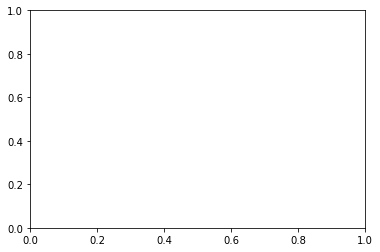

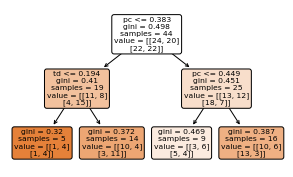

 91%|███████████████████████████████████████▎   | 84/92 [00:34<00:03,  2.55it/s]

84
Node_1
(5, 19)
(0, 19)
0
0
Node_2
(14, 19)
(7, 19)
LR Model
7
7
Node_3
(9, 19)
(3, 19)
LR Model
10
10
Node_4
(16, 19)
(12, 19)
LR Model
22
22
720579
Assay:  720533
Inactive Compounds  39
Active Compounds  105
Active Compounds (after Undersamplimg)  39
Total Compounds (after Undersamplimg)  78
78
36
Herirachal model for training data


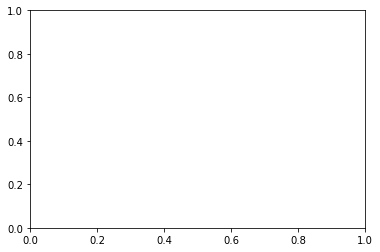

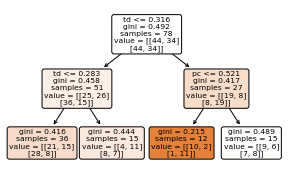

 92%|███████████████████████████████████████▋   | 85/92 [00:34<00:02,  2.56it/s]

85
Node_1
(36, 19)
(8, 19)
LR Model
8
8
Node_2
(15, 19)
(8, 19)
LR Model
16
16
Node_3
(12, 19)
(3, 19)
LR Model
19
19
Node_4
(15, 19)
(17, 19)
only positive variables in train but test compounds present, take average:
720533
Assay:  720542
Inactive Compounds  62
Active Compounds  21
Inactive Compounds (after Undersamplimg)  21
Total Compounds (after Undersamplimg)  42
42
21
Herirachal model for training data


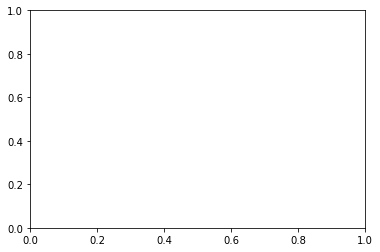

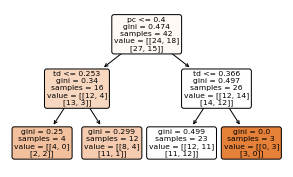

 93%|████████████████████████████████████████▏  | 86/92 [00:34<00:02,  2.55it/s]

86
Node_1
(4, 19)
(1, 19)
only positive variables in train but test compounds present, take average:
Node_2
(12, 19)
(5, 19)
LR Model
6
6
Node_3
(23, 19)
(10, 19)
LR Model
16
16
Node_4
(3, 19)
(5, 19)
LR Model
21
21
720542
Assay:  720580
Inactive Compounds  36
Active Compounds  60
Active Compounds (after Undersamplimg)  36
Total Compounds (after Undersamplimg)  72
72
25
Herirachal model for training data


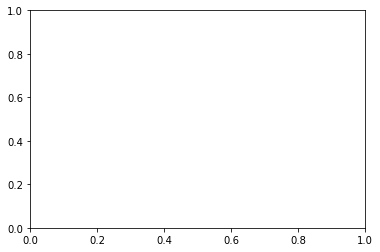

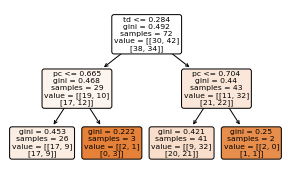

 95%|████████████████████████████████████████▋  | 87/92 [00:35<00:01,  2.56it/s]

87
Node_1
(26, 19)
(10, 19)
LR Model
10
10
Node_2
(3, 19)
(1, 19)
LR Model
11
11
Node_3
(41, 19)
(13, 19)
LR Model
24
24
Node_4
(2, 19)
(1, 19)
LR Model
25
25
720580
Assay:  720504
Inactive Compounds  25
Active Compounds  77
Active Compounds (after Undersamplimg)  25
Total Compounds (after Undersamplimg)  50
50
26
Herirachal model for training data


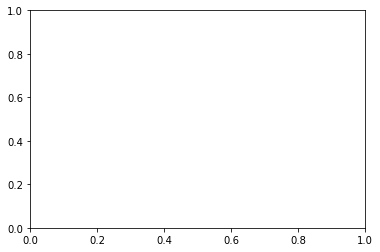

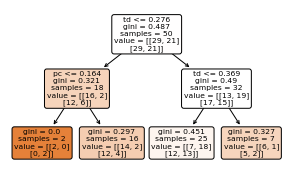

 96%|█████████████████████████████████████████▏ | 88/92 [00:35<00:01,  2.58it/s]

88
Node_1
(2, 19)
(1, 19)
only negative variables in train but test compounds present, take average:
Node_2
(16, 19)
(4, 19)
LR Model
5
5
Node_3
(25, 19)
(17, 19)
LR Model
22
22
Node_4
(7, 19)
(4, 19)
only positive variables in train but test compounds present, take average:
720504
Assay:  720532
Inactive Compounds  73
Active Compounds  167
Active Compounds (after Undersamplimg)  73
Total Compounds (after Undersamplimg)  146
146
61
Herirachal model for training data


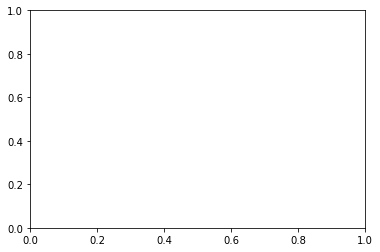

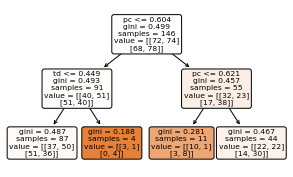

 97%|█████████████████████████████████████████▌ | 89/92 [00:36<00:01,  2.59it/s]

89
Node_1
(87, 19)
(18, 19)
LR Model
18
18
Node_2
(4, 19)
(6, 19)
only positive variables in train but test compounds present, take average:
Node_3
(11, 19)
(5, 19)
LR Model
29
29
Node_4
(44, 19)
(32, 19)
LR Model
61
61
720532
Assay:  1159524
Inactive Compounds  528
Active Compounds  176
Inactive Compounds (after Undersamplimg)  176
Total Compounds (after Undersamplimg)  352
352
176
Herirachal model for training data


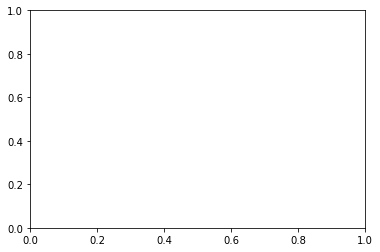

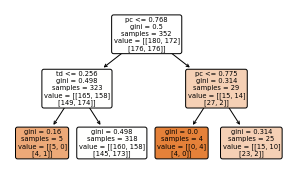

 98%|██████████████████████████████████████████ | 90/92 [00:36<00:00,  2.55it/s]

90
Node_1
(5, 19)
(1, 19)
LR Model
1
1
Node_2
(318, 19)
(154, 19)
LR Model
155
155
Node_3
(4, 19)
(3, 19)
LR Model
158
158
Node_4
(25, 19)
(18, 19)
LR Model
176
176
1159524
Assay:  1117304
Inactive Compounds  207
Active Compounds  101
Inactive Compounds (after Undersamplimg)  101
Total Compounds (after Undersamplimg)  202
202
78
Herirachal model for training data


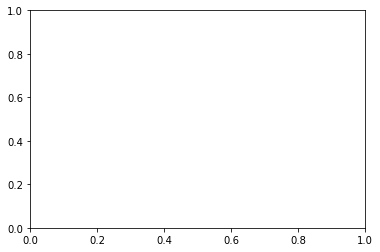

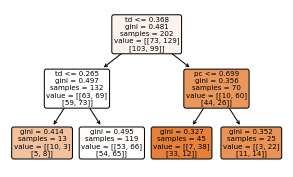

 99%|██████████████████████████████████████████▌| 91/92 [00:36<00:00,  2.43it/s]

91
Node_1
(13, 19)
(3, 19)
LR Model
3
3
Node_2
(119, 19)
(35, 19)
LR Model
38
38
Node_3
(45, 19)
(28, 19)
LR Model
66
66
Node_4
(25, 19)
(12, 19)
LR Model
78
78
1117304
Assay:  1117305
Inactive Compounds  197
Active Compounds  90
Inactive Compounds (after Undersamplimg)  90
Total Compounds (after Undersamplimg)  180
180
72
Herirachal model for training data


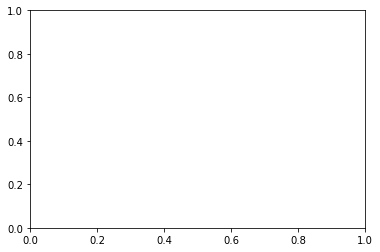

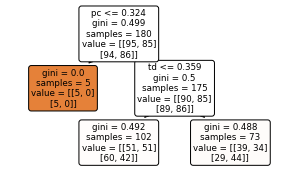

100%|███████████████████████████████████████████| 92/92 [00:37<00:00,  2.47it/s]

92
Node_1
(5, 19)
(2, 19)
LR Model
2
2
Node_2
(102, 19)
(28, 19)
LR Model
30
30
Node_3
(73, 19)
(42, 19)
LR Model
72
72
Node_4
(0, 19)
(0, 19)
72
72
1117305


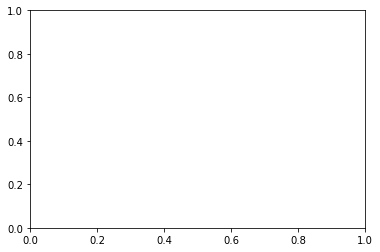

In [137]:
import warnings
warnings.filterwarnings("ignore") #ignore, default
import pandas

#sns.set(rc={'figure.figsize':(2, 2)})
#plt.rcParams['figure.dpi'] = 80
#sns.set_style("white")
metrics_list=[]
all_preds_test_compounds=pd.DataFrame(columns=['assay', 'StdInChI', 'fp_proba', 'fp_pred', 'fp_threshold', 'CP_proba',
       'CP_pred', 'CP_threshold', 'true', 'ts', 'pc', 'Data', 'MFP_Correct',
       'CP_Correct', 'fp_proba_scaled', 'CP_proba_scaled', 'simple_pred',
       'Ensemble_Correct', 'merger_pred', 'merger_Correct'])

initializek()
#for assay in tqdm(assaylist[:7]):
for assay in tqdm(list_of_lists_df.assay.unique()[:]):
    
    print("Assay: ", assay)
    detail_list=pd.DataFrame()
    detail_list = list_of_lists_df[list_of_lists_df["assay"]==assay].reset_index(drop=True)
    detail_list_test = detail_list[detail_list["Data"]=="HeldOut"]

    #print("CP")
    check_heirarchial(assay, "CP", detail_list_test.true, detail_list_test.CP_pred, detail_list_test.CP_proba)
    #sns.scatterplot(data=detail_list[detail_list["true"]==1], x="pc", y="td", hue="CP_Correct", legend=False)
    #plt.show()
    
    #print("MFP")
    check_heirarchial(assay, "MFP", detail_list_test.true, detail_list_test.fp_pred, detail_list_test.fp_proba)
    #sns.scatterplot(data=detail_list[detail_list["true"]==1], x="pc", y="td", hue="MFP_Correct", legend=False)
    #plt.show()
    
    #print("Ensemble Averaged")
    check_heirarchial(assay, "Ensemble Averaged", detail_list_test.true, detail_list_test.simple_pred, detail_list_test.simple_pred)
    #sns.scatterplot(data=detail_list[detail_list["true"]==1], x="pc", y="td", hue="simple_pred", legend=False)
    #plt.show()
    
    #print("Distance Based Merger")
    merger_df=pd.DataFrame()
    
    StdInChI_batch, true_batch, pred_batch, proba_batch = RF_Fn(assay)
    check_heirarchial(assay, "Distance Based Merger", true_batch, pred_batch, proba_batch)
    
    #print(true_batch)
    
    print(assay)
    
    merger_df["StdInChI"]=StdInChI_batch
    merger_df["merger_pred"]= pred_batch
    merger_df["true"]=true_batch
    merger_df["merger_Correct"]= merger_df["merger_pred"] == merger_df["true"]
    merger_df["assay"]=assay
    
    #.scatterplot(data=detail_list[detail_list["true"]==1], x="pc", y="td", hue="herrachial_Correct", legend=False)
    
    #For each assay combine original predictions and merger_df predictions
    #all_preds = pd.DataFrame()
    all_preds_test_compounds= pd.concat([all_preds_test_compounds, pd.merge(detail_list_test, merger_df)])

    
    
    
    

In [138]:
all_preds_test_compounds

,assay,StdInChI,fp_proba,fp_pred,fp_threshold,CP_proba,CP_pred,CP_threshold,true,ts,pc,Data,MFP_Correct,CP_Correct,fp_proba_scaled,CP_proba_scaled,simple_pred,Ensemble_Correct,merger_pred,merger_Correct
0,588458,InChI=1S/C14H15BrN2O3/c1-17(2)6-5-16-13(18)11-...,0.314086,1,0.288942,0.456960,1,0.318929,0.0,0.379310,0.302177,HeldOut,False,False,0.517681,0.601334,1.0,False,1.0,False
1,588458,InChI=1S/C23H22N2O2/c26-23(16-22-21-9-5-4-6-17...,0.236041,0,0.288942,0.204912,0,0.318929,0.0,0.481481,0.658485,HeldOut,True,True,0.408457,0.321251,0.0,True,0.0,True
2,588458,InChI=1S/C22H17F2NO3/c23-18-7-1-15(2-8-18)13-2...,0.196085,0,0.288942,0.327494,1,0.318929,0.0,0.384615,0.741548,HeldOut,True,False,0.339316,0.506288,0.0,True,0.0,True
3,588458,InChI=1S/C24H24N6O4/c25-22-20(24(31)26-7-8-29-...,0.168825,0,0.288942,0.202695,0,0.318929,0.0,0.416667,0.623549,HeldOut,True,True,0.292143,0.317774,0.0,True,0.0,True
4,588458,InChI=1S/C15H23BrN2O4S/c1-10-8-18(11(2)9-19)23...,0.251624,0,0.288942,0.476059,1,0.318929,0.0,0.454545,0.766103,HeldOut,True,False,0.435424,0.615355,1.0,False,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,1117305,InChI=1S/C12H9F3N2O2/c1-7-10(6-16-19-7)11(18)1...,0.340631,0,0.357222,0.357490,1,0.330242,0.0,0.296296,0.479437,HeldOut,True,False,0.476778,0.520342,0.0,True,1.0,False
68,1117305,InChI=1S/C12H10N2/c1-8-12-10(6-7-13-8)9-4-2-3-...,0.242578,0,0.357222,0.244216,0,0.330242,0.0,0.363636,0.619949,HeldOut,True,True,0.339534,0.369752,0.0,True,0.0,True
69,1117305,InChI=1S/C8H4Cl2N2O2/c9-3-1-5-6(2-4(3)10)12-8(...,0.403774,1,0.357222,0.352388,1,0.330242,1.0,0.333333,0.541732,HeldOut,True,True,0.536212,0.516533,1.0,True,1.0,True
70,1117305,InChI=1S/C15H12O5/c16-9-3-1-8(2-4-9)13-7-12(19...,0.478660,1,0.357222,0.243638,0,0.330242,0.0,0.444444,0.506977,HeldOut,False,True,0.594464,0.368877,0.0,True,0.0,True


In [141]:
all_preds_test_compounds.to_csv("Predictions_train_heldout_scaled_prob_all_assays_ensemble_merger_test_compounds.csv", index=False)

In [139]:
metrics_list = pd.DataFrame(metrics_list,columns=["assay","method","f1", "precision", "Sensitivity", "Specificity", "ba", "mcc", "AUC"])
metrics_list

,assay,method,f1,precision,Sensitivity,Specificity,ba,mcc,AUC
0,588458,CP,0.156863,0.137931,0.181818,0.632353,0.407086,-0.170889,0.366979
1,588458,MFP,0.466667,0.368421,0.636364,0.647059,0.641711,0.246608,0.709893
2,588458,Ensemble Averaged,0.200000,0.222222,0.181818,0.794118,0.487968,-0.025854,0.487968
3,588458,Distance Based Merger,0.421053,0.342857,0.545455,0.661765,0.603610,0.182676,0.727941
4,588334,CP,0.441860,0.316667,0.730769,0.487500,0.609135,0.189483,0.608654
...,...,...,...,...,...,...,...,...,...
363,1117304,Distance Based Merger,0.588235,0.465116,0.800000,0.566038,0.683019,0.343452,0.664906
364,1117305,CP,0.250000,0.205882,0.318182,0.460000,0.389091,-0.204674,0.455455
365,1117305,MFP,0.478261,0.458333,0.500000,0.740000,0.620000,0.234521,0.571818
366,1117305,Ensemble Averaged,0.350000,0.388889,0.318182,0.780000,0.549091,0.104447,0.549091


In [140]:
metrics_list.to_csv("All_metrics.csv", index=False)